# E-commerce

In [299]:
# import libraries
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, \
make_scorer, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, GRU, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import F1Score
import keras.backend as K
import tensorflow as tf
from keras_tuner import RandomSearch, BayesianOptimization
import logging
from textblob import TextBlob

from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import gensim
from gensim.models import LdaModel
from gensim import corpora
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')

## Project Task: Week 1

### Class Imbalance Problem:

#### 1. Perform an EDA on the dataset

In [147]:
# Get Ecomerce dataset

ecom_df_train = pd.read_csv('train_data.csv')
ecom_df_test = pd.read_csv('test_data.csv')
ecom_df_test_hidden = pd.read_csv('test_data_hidden.csv')

In [148]:
# info

print('train shape ', ecom_df_train.shape)
print('test shape', ecom_df_test.shape)
print('test hidden shape', ecom_df_test_hidden.shape)

train shape  (4000, 8)
test shape (1000, 7)
test hidden shape (1000, 8)


In [149]:
ecom_df_train.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [150]:
ecom_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB


There are few nan data in reviews.title, others are fine.

##### a. See what a positive, negative, and neutral review looks like

In [151]:
# reiew sample
print('\npositive\n-----------------------')
print(ecom_df_train[ecom_df_train['sentiment'] == 'Positive']['reviews.text'][:1].values)

print('\nNegative\n-----------------------')
print(ecom_df_train[ecom_df_train['sentiment'] == 'Negative']['reviews.text'][:1].values)

print('\nNeutral\n-----------------------')
print(ecom_df_train[ecom_df_train['sentiment'] == 'Neutral']['reviews.text'][:1].values)


positive
-----------------------
['Purchased on Black FridayPros - Great Price (even off sale)Very powerful and fast with quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need this to subsidize the tablet and will remove the adds if you pay them $15.Inability to access other apps except the ones from Amazon. There is a way which I was able to accomplish to add the Google Play storeNet this is a great tablet for the money']

Negative
-----------------------
['was cheap, can not run chrome stuff, returned to store.']

Neutral
-----------------------
['Just an average Alexa option. Does show a few things on screen but still limited.']


In [152]:
# NaN check
ecom_df_train.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [153]:
ecom_df_train[ecom_df_train['reviews.title'].isna()][:1]

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
834,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-29T16:56:05.000Z,Best New Adult Toy in years! Wish I had purcha...,NaN,Positive


As we are mainly focusing on the review texts, so review title is optional. So we can leave it as it is.

##### b. Check the class count for each class. It’s a class imbalance problem.

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64
-----------------
Positive    0.93725
Neutral     0.03950
Negative    0.02325
Name: sentiment, dtype: float64


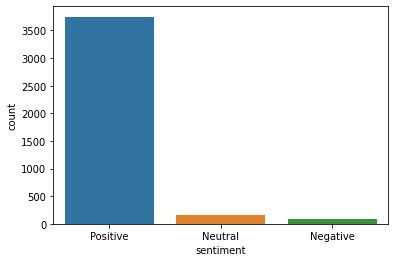

In [154]:
# Review type counts

print(ecom_df_train.sentiment.value_counts())
print('-----------------')
print(ecom_df_train.sentiment.value_counts(normalize=True))
sns.countplot(ecom_df_train.sentiment)
plt.show()

Its highly imbalanced dataset having lots of positive reviews and less negative and neutral reviews.

So while modelling, we need to take this data imbalance into consideration.

### EDA

In [155]:
ecom_df_train.columns

Index(['name', 'brand', 'categories', 'primaryCategories', 'reviews.date',
       'reviews.text', 'reviews.title', 'sentiment'],
      dtype='object')

In [156]:
# unisuq values for each columes
print('Name unique counts', ecom_df_train.name.nunique())
print('Brand unique counts', ecom_df_train.brand.nunique())
print('Categories unique counts', ecom_df_train.categories.nunique())
print('PrimaryCategories unique counts', ecom_df_train.primaryCategories.nunique())
print('Reviews date unique counts', ecom_df_train['reviews.date'].nunique())
print('Reviews text unique counts', ecom_df_train['reviews.text'].nunique())
print('Reviews title unique counts', ecom_df_train['reviews.title'].nunique())
print('Sentiment unique counts', ecom_df_train['sentiment'].nunique())

Name unique counts 23
Brand unique counts 1
Categories unique counts 23
PrimaryCategories unique counts 4
Reviews date unique counts 638
Reviews text unique counts 3598
Reviews title unique counts 2606
Sentiment unique counts 3


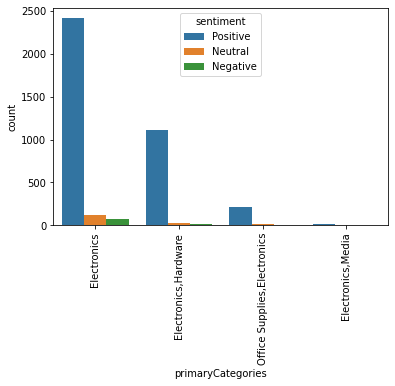

In [157]:
sns.countplot(data=ecom_df_train, x= 'primaryCategories', hue='sentiment')
plt.xticks(rotation=90)
plt.show()

We have most of the reviews from the Electronics category followed by electronic hardware. But everywhere the positive reviews are way high as compared to others.

Here we are mainly focusing on review text to analyse it to get the possible sentiment. Other column values can be ignored.

In [158]:
ecom_df_train['reviews.size'] = ecom_df_train['reviews.text'].apply(len)

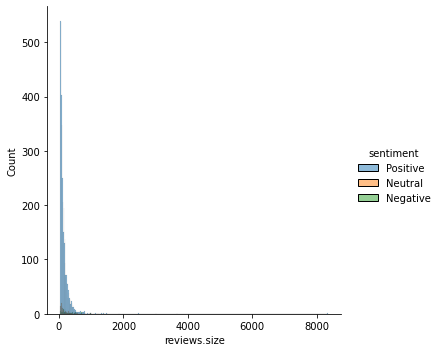

In [159]:
sns.displot(ecom_df_train, x='reviews.size', hue= 'sentiment')
plt.show()

It seems most of the reviews have 100-150 characters, but still there are few reviews with long texts as well.

In [160]:
print('Mean review size for positive reviews', ecom_df_train['reviews.size'][ecom_df_train['sentiment'] == 'Positive'].median())
print('Mean review size for neutral reviews', ecom_df_train['reviews.size'][ecom_df_train['sentiment'] == 'Neutral'].median())
print('Mean review size for negative reviews', ecom_df_train['reviews.size'][ecom_df_train['sentiment'] == 'Negative'].median())

Mean review size for positive reviews 104.0
Mean review size for neutral reviews 123.5
Mean review size for negative reviews 162.0


Avg text size is in between 100 to 150.

#### Feature engineering / text cleaning

We can now clean the review texts by removing unwanted letters, punctuations and stop words.

It would be helpful on building models that will focus on important words responsible for sentiment prediction.

In [161]:
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'[a-z]+')
stowords_en = stopwords.words("english")
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [162]:
def preprocess(text):
    text_cln = BeautifulSoup(text, 'lxml').get_text()
    text_cln = re.sub("[^a-zA-Z]", "", text_cln)
    text_cln = ''.join([c for c in text if c not in string.punctuation])
    text_cln = text_cln.lower()
    text_cln = tokenizer.tokenize(text_cln)
    text_cln = [stemmer.stem(word) for word in text_cln if word not in stowords_en]
    return ' '.join(text_cln)

In [163]:
ecom_df_train['reviews.clean_text'] = ecom_df_train['reviews.text'].apply(preprocess)

In [164]:
ecom_df_train['reviews.clean_text'][0]

'purchas black fridaypro great price even saleveri power fast quad core processor amaz soundwel builtcon amazon ad amazon need subsid tablet remov add pay inabl access app except one amazon way abl accomplish add googl play storenet great tablet money'

In [165]:
ecom_df_test['reviews.clean_text'] = ecom_df_test['reviews.text'].apply(preprocess)

In [166]:
ecom_df_test_hidden['reviews.clean_text'] = ecom_df_test_hidden['reviews.text'].apply(preprocess)

Lets save all the three review texts for future purposes.

We are going to use the preprocessed cleaned review texts and the coresponding sentiments. So lets only take these two columns for each dataframes. For computing sentiment score, we can try with raw and cleaned review texts. So lets keep all the three columns.

In [168]:
ecom_df_train = ecom_df_train[['reviews.text','reviews.clean_text', 'sentiment']]
ecom_df_test = ecom_df_test[['reviews.text', 'reviews.clean_text']]
ecom_df_test_hidden = ecom_df_test_hidden[['reviews.text', 'reviews.clean_text', 'sentiment']]

In [169]:
ecom_df_train.to_pickle("ecomp_train_processed.pkl")
ecom_df_test_hidden.to_pickle("ecomp_test_hidden_processed.pkl")
ecom_df_test.to_pickle("ecomp_test_processed.pkl")

##### Train test split for modeling

In [ ]:
X = ecom_df_train['reviews.clean_text']
y = ecom_df_train['sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#### 2. Convert the reviews in Tf-Idf score.

TFIDF is a function to process the input text to generate n-dim feature vector. As to build model, we need n-dim vectors to represent each data as datapoints in n-dim space, we need to use TF_IDF vectorization. It uses term frequency and inverse document frequency to give more score to important words used in a review, which is helpful to represent a text review in vector form.

CountVectorizer can also be an option. TFIDF is better than that.

We can customize it as per our need like, we can set params like maximum feature length, min-max word count, n-gram range etc to improve its performance.

Below function can be used to train and use TFIDF vectorizer model, or an already trained model to get the feature vector for a text input.

In [170]:
tfidf = TfidfVectorizer(max_features = 5000, max_df=10, min_df=3, ngram_range=(1, 2))

def text_transform(x_train, x_test):
    if x_train is not None:
        x_train_vec = tfidf.fit_transform(x_train)
    if x_test is None:
        return x_train_vec
    x_test_vec = tfidf.transform(x_test)
    return x_test_vec if x_train is None else (x_train_vec, x_test_vec)

In [ ]:
x_train_vec, x_test_vec = text_transform(x_train, x_test)

In [ ]:
print(x_train_vec.shape)
print(x_test_vec.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 3215)
(800, 3215)
(3200,)
(800,)


#### 5. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

To check the model performance, we can use all the classification metrics like accuracy score, precision/recall/f1-score for individual and overall classes as a part of classification report. ROC_AUC can be also be calculated and AUC curve can be shown for each class label.

It would be helpful to compare the performance between different models as well as for different datasets (train, test etc).

We can mainly focus on the F1-score here as accuracy is not better choice for imbalance data.

In [32]:
def getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, name):
    print('accuracy score train', accuracy_score(y_train, y_pred_train))
    print('accuracy score test', accuracy_score(y_test, y_pred_test))
    
    print('\nTrain classification report: ' + name + '\n')
    print(classification_report(y_train, y_pred_train))
    print('\nTest classification report: ' + name + '\n')
    print(classification_report(y_test, y_pred_test))
    
    print('\nTrain confusion matrix: ' + name + '\n')
    print(pd.DataFrame(confusion_matrix(y_train, y_pred_train), columns=classes, index=classes))
    print('\nTest confusion matrix: ' + name + '\n')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_test), columns=classes, index=classes))
    
    train_op = OneVsRest(y_train, y_pred_train)
    test_op = OneVsRest(y_test, y_pred_test)
    for c, y_y_pred in zip(classes, train_op):
        print('\nroc auc score train class {}: {}'.format(c, roc_auc_score(y_y_pred[0], y_y_pred[1])))
        
    for c, y_y_pred in zip(classes, train_op):
        fpr, tpr, th = roc_curve(y_y_pred[0], y_y_pred[1])
        auc_val = auc(fpr, tpr)
        plt.title(name + ' Train Receiver Operating Characteristic: ' + c + ' class')
        plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_val))
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()  
        
    for c, y_y_pred in zip(classes, test_op):
        print('\nroc auc score test class {}: {}'.format(c, roc_auc_score(y_y_pred[0], y_y_pred[1]))) 
    
    for c, y_y_pred in zip(classes, test_op):
        fpr, tpr, th = roc_curve(y_y_pred[0], y_y_pred[1])
        auc_val = auc(fpr, tpr)
        plt.title(name + ' Test Receiver Operating Characteristic: ' + c + ' class')
        plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_val))
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [33]:
def OneVsRest(y, y_pred):
    outputs = []
    for c in classes:
        y_one = list(map(lambda x: 1 if x==c else 0, y))
        y_one_red = list(map(lambda x: 1 if x==c else 0, y_pred))
        outputs.append((y_one, y_one_red))
    return outputs 

#### 3. Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance.

Multinomal Naive Bayes works as per the naive bayes rule considering the prior probabilities. Its a best choice for texual data.

We can train the model and get sentiment prediction for both train test data and get the model performance using the predicted and actual sentiments.

This steps can be followed for all the models now onwards.

##### Multinomial Naive Bayes

In [ ]:
mul_nb_model = MultinomialNB()

In [ ]:
mul_nb_model.fit(x_train_vec, y_train)
y_pred_train = mul_nb_model.predict(x_train_vec)
y_pred_test = mul_nb_model.predict(x_test_vec)

In [ ]:
classes = mul_nb_model.classes_

accuracy score train 0.9396875
accuracy score test 0.9375

Train classification report: Naive Bayes

              precision    recall  f1-score   support

    Negative       1.00      0.08      0.15        74
     Neutral       0.60      0.05      0.09       127
    Positive       0.94      1.00      0.97      2999

    accuracy                           0.94      3200
   macro avg       0.85      0.38      0.40      3200
weighted avg       0.93      0.94      0.91      3200


Test classification report: Naive Bayes

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        19
     Neutral       0.00      0.00      0.00        31
    Positive       0.94      1.00      0.97       750

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800


Train confusion matrix: Naive Bayes

          Negative  Neutral  Positive
Negative         6 

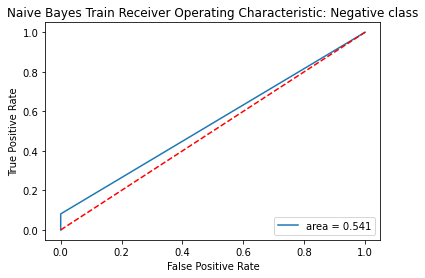

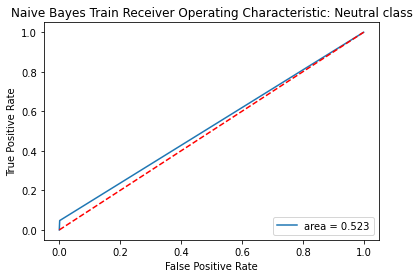

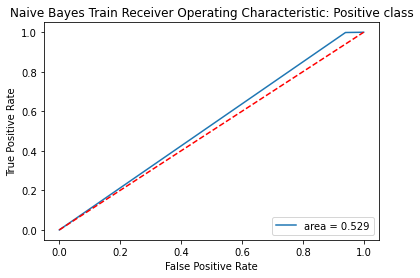


roc auc score test class Negative: 0.5

roc auc score test class Neutral: 0.5

roc auc score test class Positive: 0.5


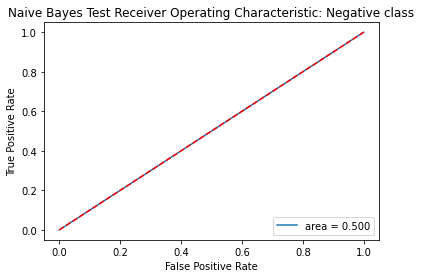

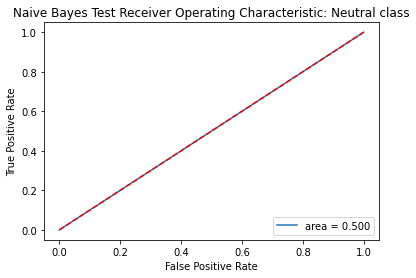

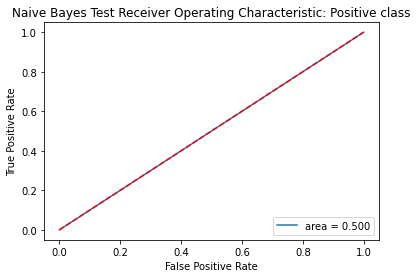

In [ ]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'Naive Bayes')

Now test for the test dataset

In [ ]:
test_x_vec = text_transform(None, ecom_df_test_hidden['reviews.clean_text'])
test_y = ecom_df_test_hidden['sentiment']

In [ ]:
test_y_pred = mul_nb_model.predict(test_x_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.939 

Classification report

              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08        24
     Neutral       1.00      0.03      0.05        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.98      0.36      0.37      1000
weighted avg       0.94      0.94      0.91      1000



In [ ]:
# save model
pickle.dump(mul_nb_model, open('nb.pkl', 'wb'))

We can see all the reviews have been assigned to 'Positive' sentiment. The model is not performing well because of class imbalance.

### Tackling Class Imbalance Problem:

#### 4. Oversampling or undersampling can be used to tackle the class imbalance problem. 

To handle the class imbalance, we can oversample the data. SMOTE can be used for this by generating synthetic data based on the original data points.

In [ ]:
sm = SMOTE(random_state=0)

In [ ]:
X_blc, y_blc = sm.fit_resample(text_transform(X, None), y)

In [ ]:
print('After balancing, train Positive:', sum(y_blc == 'Positive'))
print('After balancing, train Neutral:', sum(y_blc == 'Neutral'))
print('After balancing, train Negtive:', sum(y_blc == 'Negative'))

After balancing, train Positive: 3749
After balancing, train Neutral: 3749
After balancing, train Negtive: 3749


Now we can see all the three sentiment types have same number of records. Now the model e build, wont face any issue related to class imbalance.

In [ ]:
x_train_vec, x_test_vec, y_train, y_test = train_test_split(X_blc, y_blc, test_size=0.2, stratify=y_blc, random_state=0)
print(x_train_vec.shape)
print(x_test_vec.shape)
print(y_train.shape)
print(y_test.shape)

(8997, 4121)
(2250, 4121)
(8997,)
(2250,)


##### MultinomialNB with data balanced

To check the oversampling impact, we can use naive bayes model and compare its performance against the same model with original data.

In [ ]:
mul_nb_model_blc = MultinomialNB()

Instead of using the model directly, we can do hyper-parameter tunning for the best possible outcome.

In [ ]:
# Hyper-parameter tunning

param = {'alpha': [0.001, 0.005, 0.1, 0.5, 1]}
gs_nb = GridSearchCV(mul_nb_model_blc, param, refit=True, scoring=make_scorer(f1_score , average='macro'))

In [ ]:
gs_nb.fit(x_train_vec, y_train)
y_pred_train = gs_nb.predict(x_train_vec)
y_pred_test = gs_nb.predict(x_test_vec)

In [ ]:
classes = gs_nb.classes_

In [ ]:
gs_nb.best_score_

0.9333371663199669

In [ ]:
gs_nb.best_params_

{'alpha': 0.001}

In [ ]:
nb_model = gs_nb.best_estimator_
nb_model

MultinomialNB(alpha=0.001)

accuracy score train 0.9496498832944315
accuracy score test 0.9488888888888889

Train classification report: Naive Bayes Balanced

              precision    recall  f1-score   support

    Negative       0.89      1.00      0.94      2999
     Neutral       0.98      0.94      0.96      2999
    Positive       1.00      0.90      0.95      2999

    accuracy                           0.95      8997
   macro avg       0.95      0.95      0.95      8997
weighted avg       0.95      0.95      0.95      8997


Test classification report: Naive Bayes Balanced

              precision    recall  f1-score   support

    Negative       0.88      1.00      0.94       750
     Neutral       0.98      0.95      0.96       750
    Positive       1.00      0.90      0.95       750

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250


Train confusion matrix: Naive Bayes Balanced

         

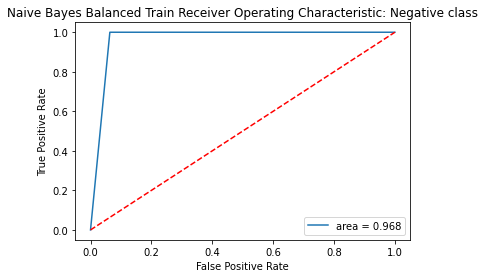

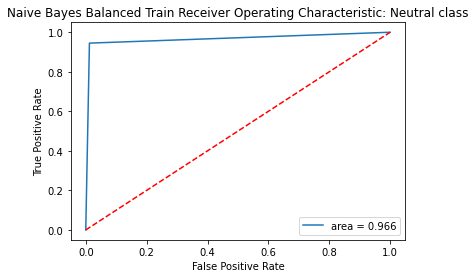

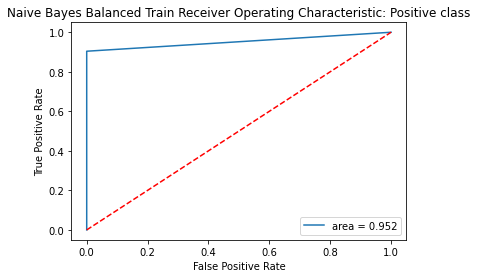


roc auc score test class Negative: 0.967

roc auc score test class Neutral: 0.9673333333333334

roc auc score test class Positive: 0.9506666666666667


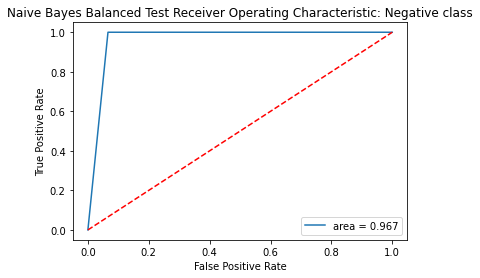

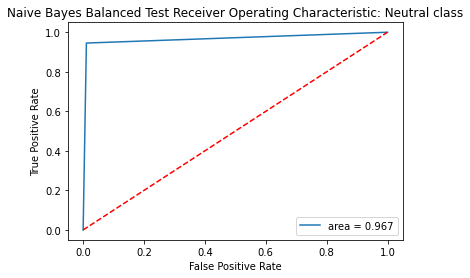

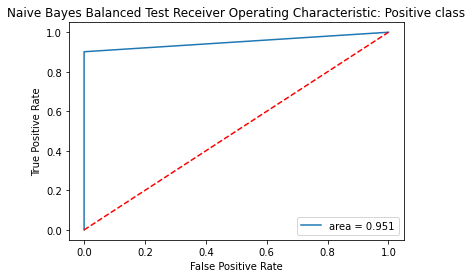

In [ ]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'Naive Bayes Balanced')

Lets check model performance on test data.

In [ ]:
test_x_vec = text_transform(None, ecom_df_test_hidden['reviews.clean_text'])
test_y = ecom_df_test_hidden['sentiment']

In [ ]:
test_y_pred = nb_model.predict(test_x_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.81 

Classification report

              precision    recall  f1-score   support

    Negative       0.10      0.46      0.16        24
     Neutral       0.20      0.33      0.25        39
    Positive       0.96      0.84      0.89       937

    accuracy                           0.81      1000
   macro avg       0.42      0.54      0.43      1000
weighted avg       0.91      0.81      0.85      1000



In [ ]:
# save model
pickle.dump(nb_model, open('nb_blc_bp.pkl', 'wb'))

In [ ]:
ecomp_test_hidden_df = pd.DataFrame.sparse.from_spmatrix(test_x_vec)
ecomp_test_hidden_df = pd.concat([ecomp_test_hidden_df, test_y], axis=1)
ecomp_test_hidden_df.to_pickle("ecomp_test_hidden_df.pkl")

From all the metrices, we can see the model performance has been improved after balanced data is used. Now no longer the score are less for the data with Negative and Neutral setiment.

#### 6. Use Tree-based classifiers like Random Forest and XGBoost.

We can go for ensamble models that can enhance the model performance as they use multiple based models with bagging boosting technique.

So we can try out RandomForest and XGBoost which use tree based model (decison tree) as their base model.

We can compare their performance and finally choose the best ML model to go for.

##### RandomForest with balanced data

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
params = {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 15],
'min_samples_split': [2, 4, 6]}
gs_rf = GridSearchCV(rf, params, refit=True, scoring=make_scorer(f1_score , average='macro'))
gs_rf.fit(x_train_vec, y_train)
y_pred_train = gs_rf.predict(x_train_vec)
y_pred_test = gs_rf.predict(x_test_vec)

In [ ]:
classes = gs_rf.classes_

In [ ]:
gs_rf.best_score_

0.6926930680555026

In [ ]:
gs_rf.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}

In [ ]:
rf_model = gs_rf.best_estimator_
rf_model

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=150)

accuracy score train 0.7037901522729799
accuracy score test 0.6995555555555556

Train classification report: Random Forest

              precision    recall  f1-score   support

    Negative       1.00      0.62      0.77      2999
     Neutral       1.00      0.49      0.66      2999
    Positive       0.53      1.00      0.69      2999

    accuracy                           0.70      8997
   macro avg       0.84      0.70      0.71      8997
weighted avg       0.84      0.70      0.71      8997


Test classification report: Random Forest

              precision    recall  f1-score   support

    Negative       0.98      0.63      0.77       750
     Neutral       0.96      0.50      0.66       750
    Positive       0.53      0.97      0.68       750

    accuracy                           0.70      2250
   macro avg       0.82      0.70      0.70      2250
weighted avg       0.82      0.70      0.70      2250


Train confusion matrix: Random Forest

          Negative  Neutral  P

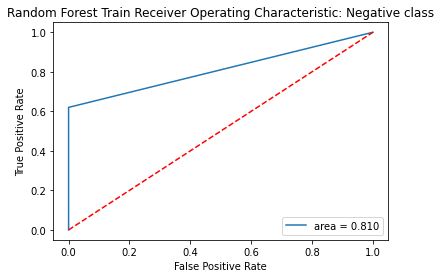

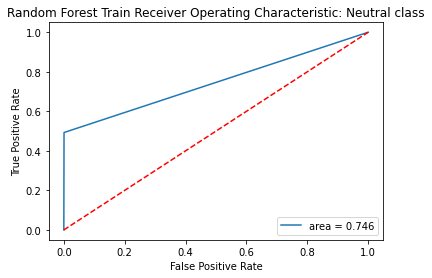

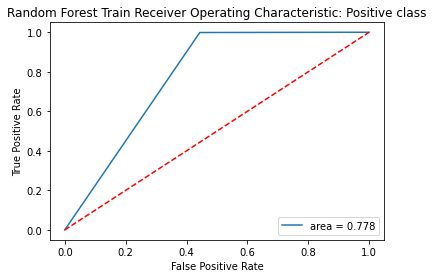


roc auc score test class Negative: 0.8133333333333332

roc auc score test class Neutral: 0.7440000000000001

roc auc score test class Positive: 0.7666666666666666


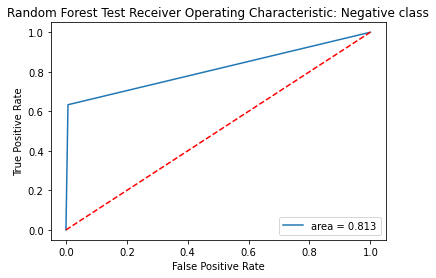

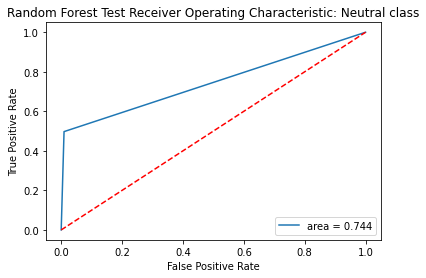

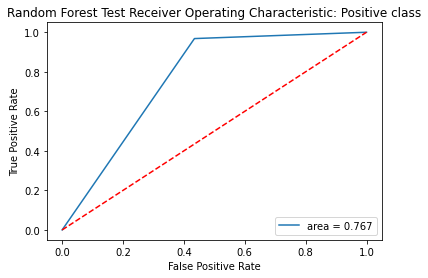

In [ ]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'Random Forest')

Lets check for test dataset.

In [ ]:
test_y_pred = rf_model.predict(test_x_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.921 

Classification report

              precision    recall  f1-score   support

    Negative       0.21      0.12      0.16        24
     Neutral       0.21      0.13      0.16        39
    Positive       0.95      0.97      0.96       937

    accuracy                           0.92      1000
   macro avg       0.46      0.41      0.43      1000
weighted avg       0.90      0.92      0.91      1000



In [ ]:
# save model
pickle.dump(rf_model, open('rf_blc_bp.pkl', 'wb'))

RandomForest gave better performance than naive bayes for the test data, but for train data, it lacks.

Next we can haveXGBoost

##### XGBoostClassifier with balanced data

In [ ]:
xgc = XGBClassifier(objective='multi:softmax')
params = {
    "gamma": [0.01, 0.05, 0.1], 
    "max_depth": [5, 10, 15],
    "n_estimators": [100, 120, 150]
}
gs_xgc = GridSearchCV(xgc, params, refit=True, scoring=make_scorer(f1_score , average='macro'))
gs_xgc.fit(x_train_vec, y_train)
y_pred_train = gs_xgc.predict(x_train_vec)
y_pred_test = gs_xgc.predict(x_test_vec)

In [ ]:
classes = gs_xgc.classes_

In [ ]:
gs_xgc.best_score_

0.920400973797509

In [ ]:
gs_xgc.best_params_

{'gamma': 0.1, 'max_depth': 15, 'n_estimators': 150}

In [ ]:
xgc_model = gs_xgc.best_estimator_
xgc_model

XGBClassifier(gamma=0.1, max_depth=15, n_estimators=150,
              objective='multi:softprob')

accuracy score train 0.942758697343559
accuracy score test 0.9182222222222223

Train classification report: XGBoost

              precision    recall  f1-score   support

    Negative       0.99      0.90      0.94      2999
     Neutral       0.99      0.95      0.97      2999
    Positive       0.87      0.98      0.92      2999

    accuracy                           0.94      8997
   macro avg       0.95      0.94      0.94      8997
weighted avg       0.95      0.94      0.94      8997


Test classification report: XGBoost

              precision    recall  f1-score   support

    Negative       0.97      0.89      0.92       750
     Neutral       0.95      0.94      0.94       750
    Positive       0.85      0.93      0.89       750

    accuracy                           0.92      2250
   macro avg       0.92      0.92      0.92      2250
weighted avg       0.92      0.92      0.92      2250


Train confusion matrix: XGBoost

          Negative  Neutral  Positive
Negative   

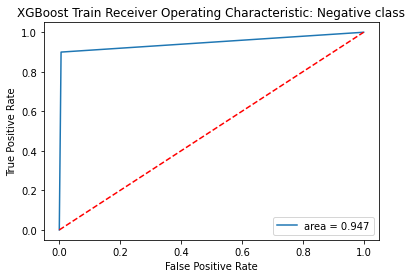

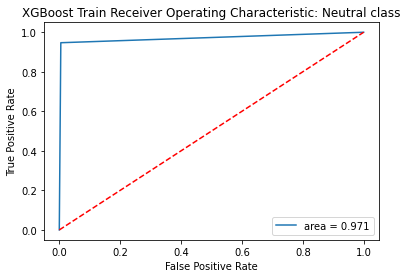

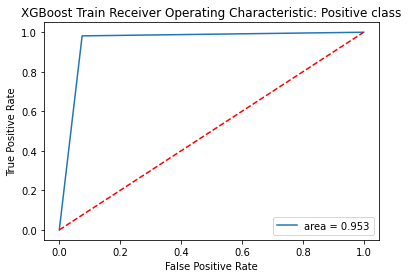


roc auc score test class Negative: 0.9359999999999999

roc auc score test class Neutral: 0.9566666666666668

roc auc score test class Positive: 0.9233333333333333


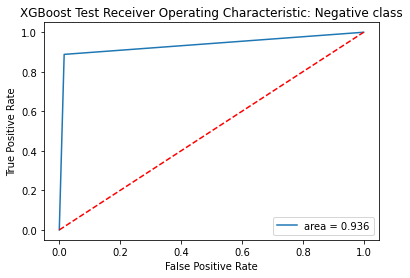

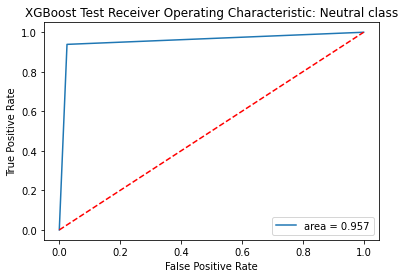

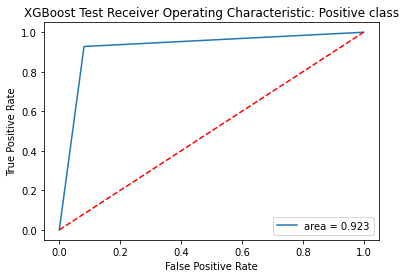

In [ ]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'XGBoost')

In [ ]:
test_y_pred = xgc_model.predict(test_x_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.91 

Classification report

              precision    recall  f1-score   support

    Negative       0.29      0.33      0.31        24
     Neutral       0.27      0.31      0.29        39
    Positive       0.96      0.95      0.95       937

    accuracy                           0.91      1000
   macro avg       0.50      0.53      0.52      1000
weighted avg       0.92      0.91      0.91      1000



In [ ]:
# save model
pickle.dump(xgc_model, open('xgc_blc_bp.pkl', 'wb'))

XGBoost performed better than Randomorest and naive bayes for the test data.

Lets save the tfid vectorizer and balanced data for future use.

In [ ]:
ecomp_train_df = pd.DataFrame.sparse.from_spmatrix(X_blc)
ecomp_train_df = pd.concat([ecomp_train_df, y_blc], axis=1)
ecomp_train_df.to_pickle("ecomp_train_df.pkl")

In [ ]:
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

So we can conclude that if it comes to using ML model for the sentiment analysis, we can use XGBoost trained with balanced and tdidf feature transformed texual data.

Below are the macro F1-score for different models with test data.

Multinomial Naive Bayes: 0.37

With balanced data,

Multinomial Naive Bayes: 0.43

RandomForestClassifier: 0.43

XGBClassifier: 0.52

##### Top 10 Important features in XGBoost

We can get the weights representing importance for the features used from XGBoost.

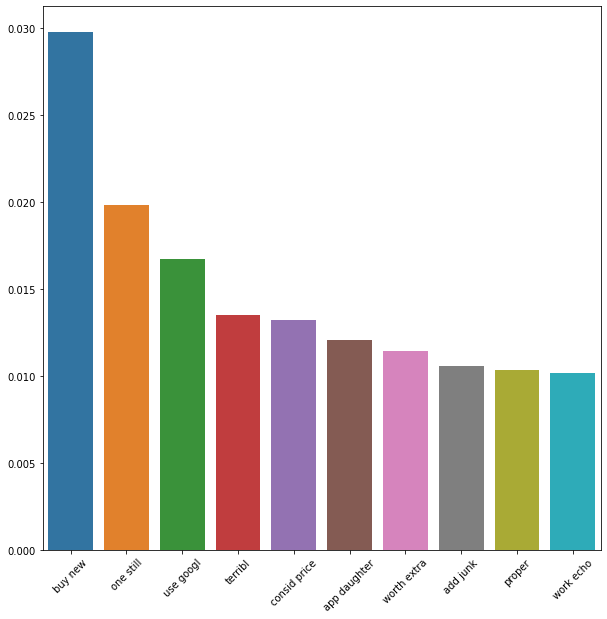

In [ ]:
feature_names = np.array(tfidf.get_feature_names())
importances = xgc_model.feature_importances_
important_feature = np.argsort(importances)[::-1][:10]
names = feature_names[important_feature]
values = importances[important_feature]

plt.figure(figsize=(10,10))
sns.barplot(names, values)
plt.xticks(rotation=45)
plt.show()

## Project Task: Week 2

We can use the tfidf vectorized balanced data for the next ML model, but the neural nets, we can use the actual preprocessed text data for sentiment prediction.

In [ ]:
ecomp_train_df = pd.read_pickle("ecomp_train_df.pkl")  
print(ecomp_train_df.shape)
ecomp_train_df.head()

(11247, 4122)


,0,1,2,3,4,5,6,7,8,9,...,4112,4113,4114,4115,4116,4117,4118,4119,4120,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


In [ ]:
ecomp_test_hidden_df = pd.read_pickle("ecomp_test_hidden_df.pkl")  
print(ecomp_test_hidden_df.shape)
ecomp_test_hidden_df.head()

(1000, 4122)


,0,1,2,3,4,5,6,7,8,9,...,4112,4113,4114,4115,4116,4117,4118,4119,4120,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


In [ ]:
test_x_vec = ecomp_test_hidden_df.drop(['sentiment'], axis=1)
test_y = ecomp_test_hidden_df['sentiment']

In [ ]:
X = ecomp_train_df.drop(['sentiment'], axis=1)
y = ecomp_train_df['sentiment']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8997, 4121)
(2250, 4121)
(8997,)
(2250,)


### Model Selection:

#### 2. Use possible ensemble techniques like: XGboost + oversampled_multinomial_NB.

Already covered on week1 (XGBoost and Multinomial NB with balanced data)

#### 3. Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

Lets use the review texts from the train and test data and compute sentiment score using TextBlob library.

In [241]:
ecom_df_train = pd.read_pickle("ecomp_train_processed.pkl")
ecom_df_test_hidden = pd.read_pickle("ecomp_test_hidden_processed.pkl")

We can create the TFIDF feature vectors with the cleaned text and use it with the sentiment score we get from both plain and clean texts separately.

In [242]:
X = ecom_df_train['reviews.clean_text']
X_ = ecom_df_train['reviews.text']
y = ecom_df_train['sentiment']

In [243]:
test_cln_X = ecom_df_test_hidden['reviews.clean_text']
test_X = ecom_df_test_hidden['reviews.text']
test_y = ecom_df_test_hidden['sentiment']
test_X_vec = text_transform(None, test_cln_X)

In [244]:
x_cln_train, x_cln_test, x_train, x_test, y_train, y_test = train_test_split(X, X_, y, test_size=0.2, stratify=y, random_state=0)

print(x_cln_train.shape)
print(x_cln_test.shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200,)
(800,)
(3200,)
(800,)
(3200,)
(800,)


In [245]:
x_train_vec, x_test_vec = text_transform(x_cln_train, x_cln_test)
print(x_train_vec.shape)
print(x_test_vec.shape)

(3200, 3215)
(800, 3215)


Lets try XGBoost model without the sentiment score data, then we can compare with the model with sentiment score.

In [259]:
xgb = XGBClassifier(gamma=0.1, max_depth=15, n_estimators=150,
              objective='multi:softprob')

In [261]:
xgb.fit(x_train_vec, y_train)
y_pred_train = xgb.predict(x_train_vec)
y_pred_test = xgb.predict(x_test_vec)

In [262]:
classes = xgb.classes_

accuracy score train 0.9684375
accuracy score test 0.93

Train classification report: XGBoost

              precision    recall  f1-score   support

    Negative       1.00      0.58      0.74        74
     Neutral       0.94      0.47      0.63       127
    Positive       0.97      1.00      0.98      2999

    accuracy                           0.97      3200
   macro avg       0.97      0.68      0.78      3200
weighted avg       0.97      0.97      0.96      3200


Test classification report: XGBoost

              precision    recall  f1-score   support

    Negative       1.00      0.11      0.19        19
     Neutral       0.24      0.13      0.17        31
    Positive       0.94      0.98      0.96       750

    accuracy                           0.93       800
   macro avg       0.73      0.41      0.44       800
weighted avg       0.92      0.93      0.91       800


Train confusion matrix: XGBoost

          Negative  Neutral  Positive
Negative        43        1      

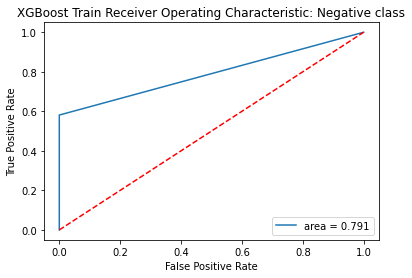

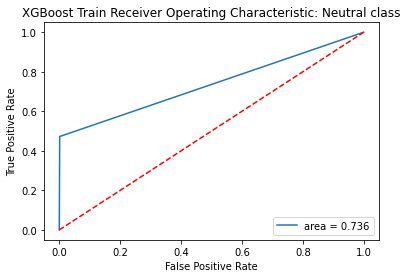

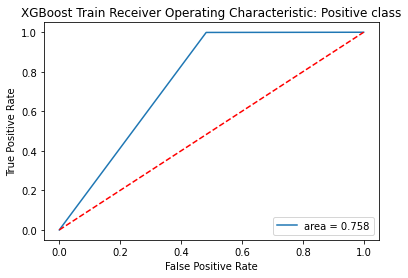


roc auc score test class Negative: 0.5526315789473684

roc auc score test class Neutral: 0.5560635932715298

roc auc score test class Positive: 0.562


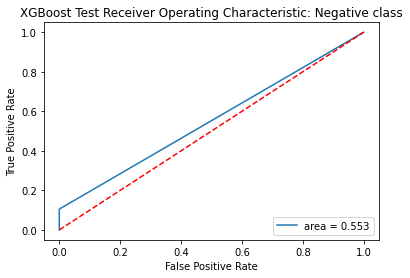

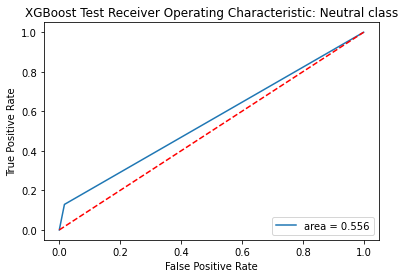

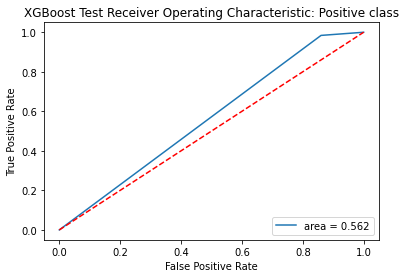

In [263]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'XGBoost')

In [264]:
test_y_pred = xgb.predict(test_X_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.935 

Classification report

              precision    recall  f1-score   support

    Negative       0.50      0.21      0.29        24
     Neutral       0.41      0.18      0.25        39
    Positive       0.95      0.99      0.97       937

    accuracy                           0.94      1000
   macro avg       0.62      0.46      0.50      1000
weighted avg       0.92      0.94      0.92      1000



We can set the scores as 0, 5 and 10 for negative, neutral and positive sentiments (score returned from the textBlob polarity can be maped to these values for better performance)

In [246]:
# textBlob
def getScore(text):
  score = round(TextBlob(text).sentiment.polarity, 3)
  if score > 0:
    return 10
  elif score < 0:
    return 0
  else:
    return 5    

In [285]:
# score with raw text
train_score1 = x_train.apply(getScore).values
train_score1 = train_score1.reshape(-1,1)
test_score1 = x_test.apply(getScore).values
test_score1 = test_score1.reshape(-1,1)
# score with cleaned text
train_score2 = x_cln_train.apply(getScore).values
train_score2 = train_score2.reshape(-1,1)
test_score2 = x_cln_test.apply(getScore).values
test_score2 = test_score2.reshape(-1,1)

In [273]:
x_train_vec1 = hstack(blocks= (x_train_vec, train_score1)).tocsr()
x_test_vec1 = hstack(blocks= (x_test_vec, test_score1)).tocsr()

In [275]:
x_train_vec2 = hstack(blocks= (x_train_vec, train_score2)).tocsr()
x_test_vec2 = hstack(blocks= (x_test_vec, test_score2)).tocsr()

In [276]:
test_test_score1 = test_X.apply(getScore).values
test_test_score1 = test_test_score1.reshape(-1,1)
test_test_score2 = test_cln_X.apply(getScore).values
test_test_score2 = test_test_score2.reshape(-1,1)

In [278]:
test_X_vec1 = hstack(blocks= (test_X_vec, test_test_score1)).tocsr()
test_X_vec2 = hstack(blocks= (test_X_vec, test_test_score2)).tocsr()

Now lets create an XGBoost model with best parameters with both of these data.

In [282]:
xgb1 = XGBClassifier(gamma=0.1, max_depth=15, n_estimators=150,
              objective='multi:softprob')

In [283]:
xgb1.fit(x_train_vec1, y_train)
y_pred_train1 = xgb1.predict(x_train_vec1)
y_pred_test1 = xgb1.predict(x_test_vec1)

In [284]:
classes = xgb1.classes_

accuracy score train 0.9721875
accuracy score test 0.93

Train classification report: XGBoost1

              precision    recall  f1-score   support

    Negative       1.00      0.65      0.79        74
     Neutral       0.96      0.53      0.68       127
    Positive       0.97      1.00      0.99      2999

    accuracy                           0.97      3200
   macro avg       0.98      0.73      0.82      3200
weighted avg       0.97      0.97      0.97      3200


Test classification report: XGBoost1

              precision    recall  f1-score   support

    Negative       1.00      0.11      0.19        19
     Neutral       0.26      0.16      0.20        31
    Positive       0.95      0.98      0.96       750

    accuracy                           0.93       800
   macro avg       0.74      0.42      0.45       800
weighted avg       0.92      0.93      0.92       800


Train confusion matrix: XGBoost1

          Negative  Neutral  Positive
Negative        48        0   

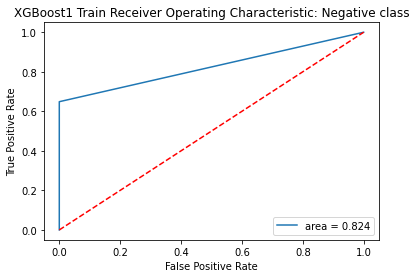

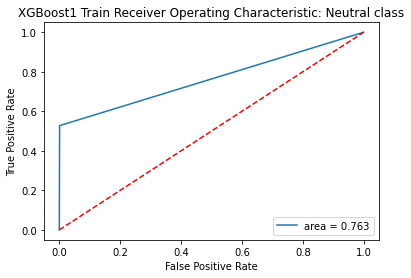

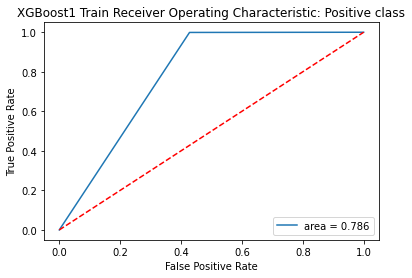


roc auc score test class Negative: 0.5526315789473684

roc auc score test class Neutral: 0.5715424304710769

roc auc score test class Positive: 0.5713333333333334


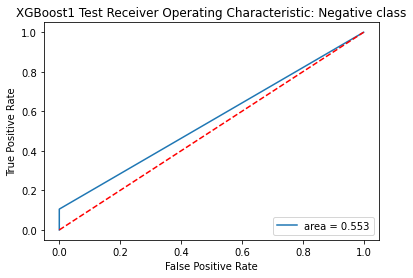

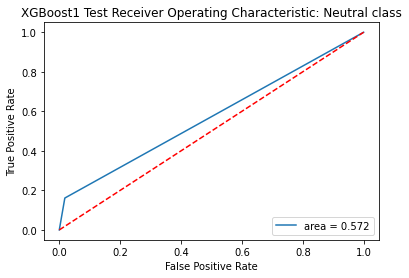

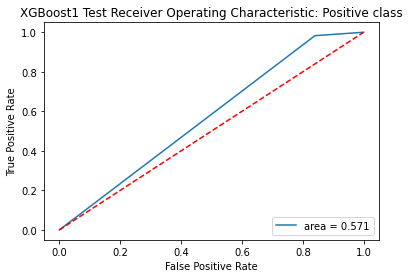

In [286]:
getPerformance(y_train, y_pred_train1, y_test, y_pred_test1, classes, 'XGBoost1')

In [287]:
test_y_pred1 = xgb1.predict(test_X_vec1)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred1)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred1))

Test accuracy score 0.937 

Classification report

              precision    recall  f1-score   support

    Negative       0.71      0.21      0.32        24
     Neutral       0.32      0.15      0.21        39
    Positive       0.95      0.99      0.97       937

    accuracy                           0.94      1000
   macro avg       0.66      0.45      0.50      1000
weighted avg       0.92      0.94      0.92      1000



In [288]:
xgb2 = XGBClassifier(gamma=0.1, max_depth=15, n_estimators=150,
              objective='multi:softprob')

In [290]:
xgb2.fit(x_train_vec2, y_train)
y_pred_train2 = xgb2.predict(x_train_vec2)
y_pred_test2 = xgb2.predict(x_test_vec2)

In [291]:
classes = xgb2.classes_

accuracy score train 0.9684375
accuracy score test 0.93

Train classification report: XGBoost2

              precision    recall  f1-score   support

    Negative       1.00      0.59      0.75        74
     Neutral       0.97      0.46      0.62       127
    Positive       0.97      1.00      0.98      2999

    accuracy                           0.97      3200
   macro avg       0.98      0.68      0.78      3200
weighted avg       0.97      0.97      0.96      3200


Test classification report: XGBoost2

              precision    recall  f1-score   support

    Negative       1.00      0.11      0.19        19
     Neutral       0.20      0.10      0.13        31
    Positive       0.94      0.99      0.96       750

    accuracy                           0.93       800
   macro avg       0.71      0.40      0.43       800
weighted avg       0.92      0.93      0.91       800


Train confusion matrix: XGBoost2

          Negative  Neutral  Positive
Negative        44        0   

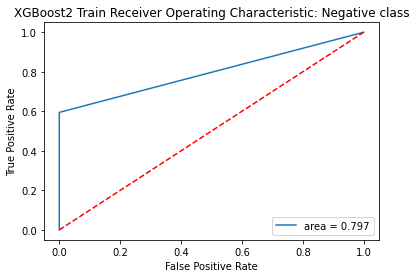

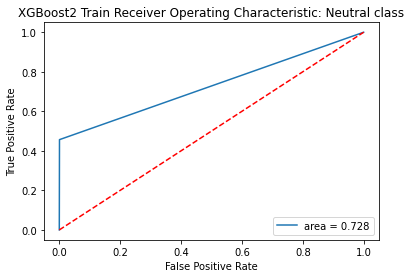

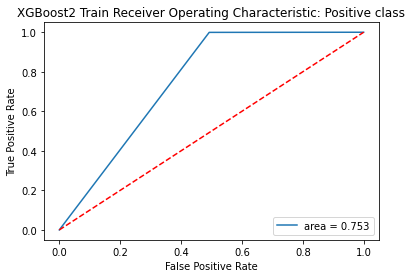


roc auc score test class Negative: 0.5526315789473684

roc auc score test class Neutral: 0.5405847560719829

roc auc score test class Positive: 0.5526666666666666


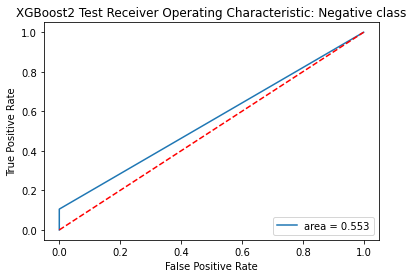

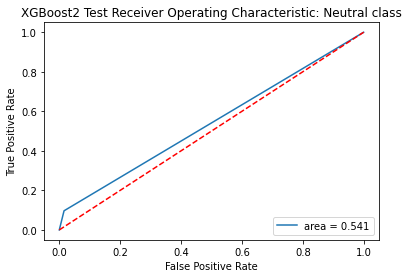

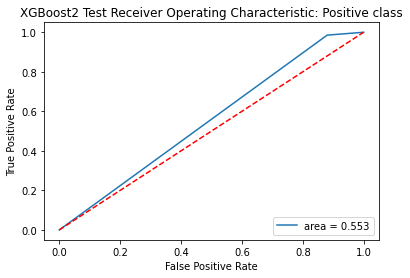

In [292]:
getPerformance(y_train, y_pred_train2, y_test, y_pred_test2, classes, 'XGBoost2')

In [293]:
test_y_pred2 = xgb2.predict(test_X_vec2)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred2)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred2))

Test accuracy score 0.937 

Classification report

              precision    recall  f1-score   support

    Negative       0.50      0.21      0.29        24
     Neutral       0.27      0.08      0.12        39
    Positive       0.95      0.99      0.97       937

    accuracy                           0.94      1000
   macro avg       0.57      0.43      0.46      1000
weighted avg       0.91      0.94      0.92      1000



In [294]:
pickle.dump(xgb1, open('xgc_with_sentiment_score.pkl', 'wb'))

From the train and test data performance for all the three XGBClassifier models, we can see that model trained with the sentiment score generated by raw/original review texts has performed better than rest of the models.

Lets find out the feature importances. Hopefuly sentiment score should get high importance.

##### Top 10 important features for XGBoost model with sentiment score

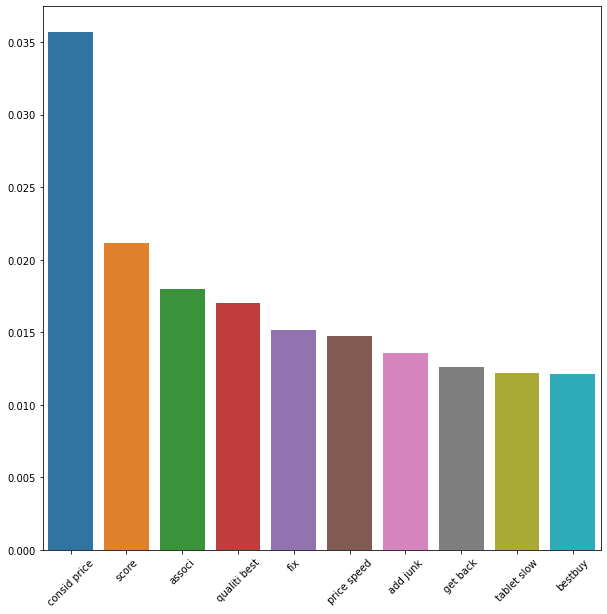

In [298]:
feature_names = np.array(tfidf.get_feature_names())
feature_names = np.append(feature_names, 'score')
importances = xgb1.feature_importances_
important_feature = np.argsort(importances)[::-1][:10]
names = feature_names[important_feature]
values = importances[important_feature]

plt.figure(figsize=(10,10))
sns.barplot(names, values)
plt.xticks(rotation=45)
plt.show()

We can see 'Score' got the 2nd highest importance among all other features for this XGBoost model. So its concluded that sentiment score can be helpful in improving the model performance.

#### 1. Apply multi-class SVM’s and neural nets.

We can check performance of multi-class SVM and Neural nets.

##### SVM

In [ ]:
svm = SGDClassifier(loss='hinge', class_weight='balanced')
svm.fit(x_train, y_train)
y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)

In [ ]:
classes = svm.classes_

accuracy score train 0.9333111037012337
accuracy score test 0.8911111111111111

Train classification report: SVM

              precision    recall  f1-score   support

    Negative       0.98      0.89      0.94      2999
     Neutral       0.84      0.99      0.91      2999
    Positive       1.00      0.91      0.95      2999

    accuracy                           0.93      8997
   macro avg       0.94      0.93      0.93      8997
weighted avg       0.94      0.93      0.93      8997


Test classification report: SVM

              precision    recall  f1-score   support

    Negative       0.94      0.88      0.91       750
     Neutral       0.79      0.99      0.88       750
    Positive       1.00      0.80      0.89       750

    accuracy                           0.89      2250
   macro avg       0.91      0.89      0.89      2250
weighted avg       0.91      0.89      0.89      2250


Train confusion matrix: SVM

          Negative  Neutral  Positive
Negative      2678    

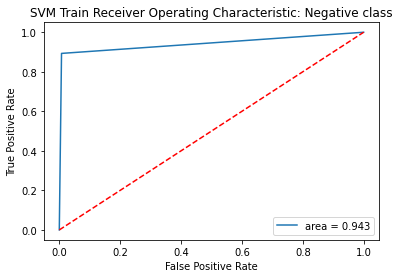

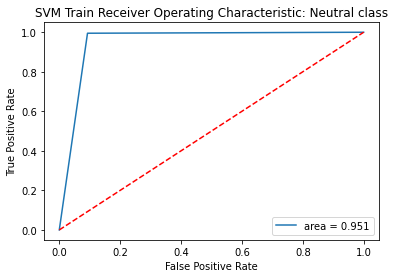

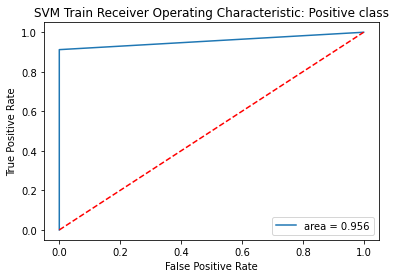


roc auc score test class Negative: 0.9259999999999999

roc auc score test class Neutral: 0.927

roc auc score test class Positive: 0.902


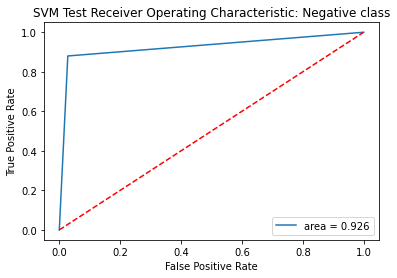

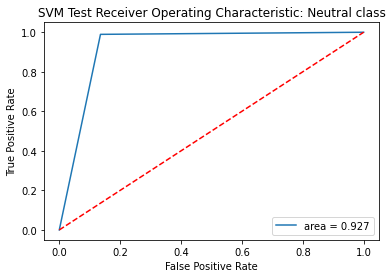

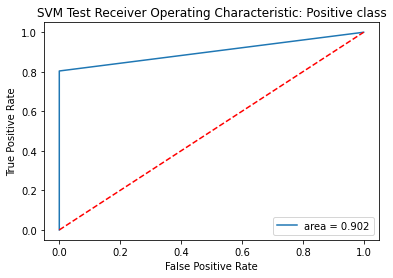

In [ ]:
getPerformance(y_train, y_pred_train, y_test, y_pred_test, classes, 'SVM')

In [ ]:
test_y_pred = svm.predict(test_x_vec)
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

Test accuracy score 0.78 

Classification report

              precision    recall  f1-score   support

    Negative       0.21      0.38      0.27        24
     Neutral       0.09      0.41      0.15        39
    Positive       0.97      0.81      0.88       937

    accuracy                           0.78      1000
   macro avg       0.42      0.53      0.43      1000
weighted avg       0.91      0.78      0.84      1000



In [ ]:
# save model
pickle.dump(svm, open('svm_blc_bp.pkl', 'wb'))

SVM model performed well, but still XGBoost is the best model till now.

#### Neural Nets

As we have text data, we can only use the RNN models for neural nets. We we can take clean preprocessed data as input and use LSTM or GRU as RNN models. Additional Dense layers and final Dense layer with Softmax activation will be used.

Also, to feed the actual text data into the LSTM/GRU, we need to encode it by using embedding.

Embedding will convert the text into work tokens and give feature vector for each of them. Keras tokenizer and sequence are also used to support word embedding.

To improve the model, categorical cross-entropy can be used as model loss metrics and f1-score will be the business metric.

In [3]:
ecomp_train = pd.read_pickle("ecomp_train_processed.pkl")

In [ ]:
ecomp_train['sentiment_score'] = ecomp_train['sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})

In [4]:
ecomp_train['sentiment_score'].value_counts()

2    3749
1     158
0      93
Name: sentiment_score, dtype: int64

In [ ]:
ecomp_train.to_pickle("ecomp_train_processed.pkl")

In [5]:
X = ecomp_train['reviews.clean_text']
y = ecomp_train['sentiment_score']
y_label = ecomp_train['sentiment']

In [6]:
x_train, x_test, y_train, y_test, y_train_label, y_test_label = train_test_split(X, y, y_label, 
                                                                                 stratify=y, test_size=0.2, 
                                                                                 random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_train.shape)

(3200,)
(800,)
(3200,)
(3200,)


In [7]:
ecomp_test_hidden = pd.read_pickle("ecomp_test_hidden_processed.pkl")
ecomp_test_hidden['sentiment_score'] = ecomp_test_hidden['sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})
ecomp_test_hidden.to_pickle("ecomp_test_hidden_processed.pkl")

In [8]:
test_X = ecomp_test_hidden['reviews.clean_text']
test_y = ecomp_test_hidden['sentiment']

### Applying LSTM (LSTM & GRU)

To build the LSTM/GRU model, we will be using embedding layer to convert the text input to feature vector suitable for LSTM/GRU input. After LSTM/GRU laer, we can add series of Dense layers of different filter size. BatchNormalization and Dropout can be used in between for better performance. In the last, one Dense layer with softmax activation will be used for classification. 

In [16]:
# initiate params
corpus_count = 20000
maxlen = 200
cat_classes = 3
epoch = 10
batch_size = 30

In [17]:
# Prepare input
tokenizer = Tokenizer(num_words=corpus_count)
tokenizer.fit_on_texts(x_train)

In [18]:
pickle.dump(tokenizer, open('keras_tokenizer.pkl', 'wb'))

In [19]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
test_X_seq = tokenizer.texts_to_sequences(test_X)

In [20]:
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen= maxlen)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen= maxlen)
test_X_seq = sequence.pad_sequences(test_X_seq, maxlen= maxlen)

In [21]:
# Encode Y values
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

In [22]:
print(x_train_seq.shape)
print(x_test_seq.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 200)
(800, 200)
(3200,)
(800,)


#### 4. Use LSTM for the previous problem (use parameters of LSTM like top-word, embedding-length, Dropout, epochs, number of layers, etc.)

#### Another variation of LSTM, GRU (Gated Recurrent Units) can be tried as well.

#### 5. Compare the accuracy of neural nets with traditional ML based algorithms.

#### LSTM

In [ ]:
# Model
model_lstm = Sequential()
model_lstm.add(Embedding(corpus_count, 150, input_length= maxlen))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(128, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_lstm.add(Dense(32, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(10, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_lstm.add(Dense(cat_classes, activation='softmax', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 150)          3000000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                      

In [ ]:
model_lstm.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model_lstm.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 49s 418ms/step - loss: 13.2222 - f1_score: 0.3224 - val_loss: 6.9888 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 44s 408ms/step - loss: 3.3632 - f1_score: 0.3313 - val_loss: 1.5788 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 44s 408ms/step - loss: 0.9832 - f1_score: 0.3225 - val_loss: 0.9169 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 45s 424ms/step - loss: 0.6539 - f1_score: 0.3225 - val_loss: 0.7162 - val_f1_score: 0.3226
Epoch 5/10
107/107 [==============================] - 44s 416ms/step - loss: 0.5260 - f1_score: 0.3225 - val_loss: 0.5642 - val_f1_score: 0.3226
Epoch 6/10
107/107 [==============================] - 45s 421ms/step - loss: 0.4337 - f1_score: 0.3225 - val_loss: 0.4900 - val_f1_score: 0.3226
Epoch 7/10
107/107 [==============================] - 45s 425ms/step - loss: 0.3891 - f1_score: 0.3225 - val_loss: 0.4437 - val_f

In [34]:
def getSentiment(y):
    d = {2: 'Positive', 1: 'Neutral', 0: 'Negative'}
    return np.array(list(map(d.get, y.argmax(axis=1))))

In [ ]:
y_pred_train = getSentiment(model_lstm.predict(x_train_seq))
y_pred_test = getSentiment(model_lstm.predict(x_test_seq))

25/25 [==============================] - 3s 116ms/step


In [35]:
classes = ['Negative', 'Neutral', 'Positive']

accuracy score train 0.9371875
accuracy score test 0.9375

Train classification report: LSTM

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        74
     Neutral       0.00      0.00      0.00       127
    Positive       0.94      1.00      0.97      2999

    accuracy                           0.94      3200
   macro avg       0.31      0.33      0.32      3200
weighted avg       0.88      0.94      0.91      3200


Test classification report: LSTM

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        19
     Neutral       0.00      0.00      0.00        31
    Positive       0.94      1.00      0.97       750

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800


Train confusion matrix: LSTM

          Negative  Neutral  Positive
Negative         0        0        74
Ne

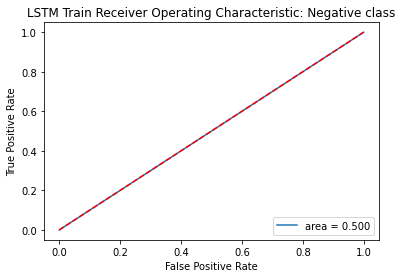

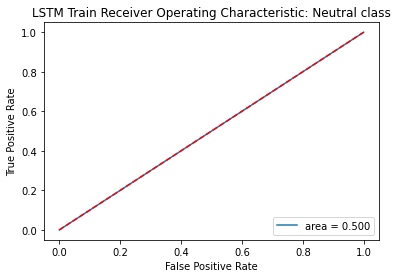

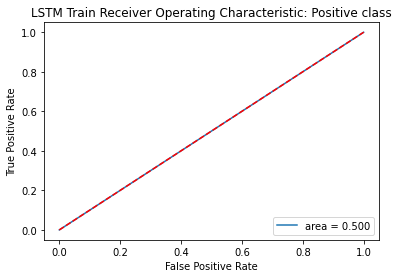


roc auc score test class Negative: 0.5

roc auc score test class Neutral: 0.5

roc auc score test class Positive: 0.5


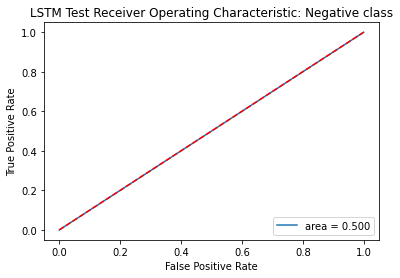

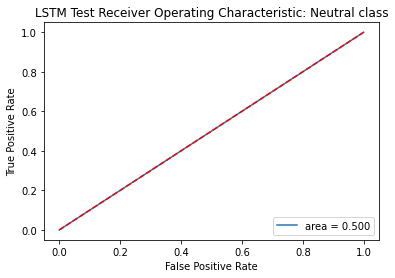

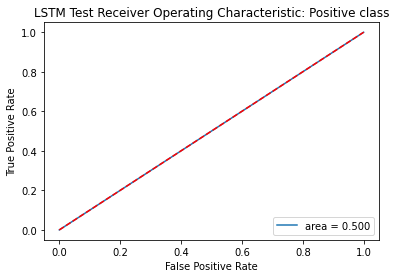

In [ ]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'LSTM')

In [ ]:
test_y_pred = getSentiment(model_lstm.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 4s 115ms/step
Test accuracy score 0.937 

Classification report

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.94      0.91      1000



In [ ]:
model_lstm.save('lstm_model')

Neural Nets LSTM didnt perform as expected. Lets try with GRU. Otherwise we can go or simple model.

#### GRU

In [ ]:
# Model
model_gru = Sequential()
model_gru.add(Embedding(corpus_count, 150, input_length= maxlen))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(128, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_gru.add(Dense(32, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(10, activation='relu', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))
model_gru.add(Dense(cat_classes, activation='softmax', kernel_regularizer= L1L2(l1=0.01, l2=0.01)))

model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 150)          3000000   
                                                                 
 gru (GRU)                   (None, 128)               107520    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                      

In [ ]:
model_gru.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [ ]:
model_gru.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 51s 441ms/step - loss: 13.4100 - f1_score: 0.3332 - val_loss: 7.6978 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 48s 448ms/step - loss: 3.9845 - f1_score: 0.3278 - val_loss: 1.9254 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 38s 359ms/step - loss: 1.1183 - f1_score: 0.3277 - val_loss: 0.9598 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 51s 479ms/step - loss: 0.6628 - f1_score: 0.3743 - val_loss: 0.7092 - val_f1_score: 0.3226
Epoch 5/10
107/107 [==============================] - 50s 473ms/step - loss: 0.5151 - f1_score: 0.4268 - val_loss: 0.5986 - val_f1_score: 0.3226
Epoch 6/10
107/107 [==============================] - 36s 333ms/step - loss: 0.4409 - f1_score: 0.3478 - val_loss: 0.5322 - val_f1_score: 0.3226
Epoch 7/10
107/107 [==============================] - 52s 483ms/step - loss: 0.3910 - f1_score: 0.3225 - val_loss: 0.4983 - val_f

In [ ]:
y_pred_train = getSentiment(model_gru.predict(x_train_seq))
y_pred_test = getSentiment(model_gru.predict(x_test_seq))

25/25 [==============================] - 2s 76ms/step


accuracy score train 0.94
accuracy score test 0.93875

Train classification report: GRU

              precision    recall  f1-score   support

    Negative       0.53      0.11      0.18        74
     Neutral       0.67      0.02      0.03       127
    Positive       0.94      1.00      0.97      2999

    accuracy                           0.94      3200
   macro avg       0.71      0.37      0.39      3200
weighted avg       0.92      0.94      0.91      3200


Test classification report: GRU

              precision    recall  f1-score   support

    Negative       1.00      0.05      0.10        19
     Neutral       0.00      0.00      0.00        31
    Positive       0.94      1.00      0.97       750

    accuracy                           0.94       800
   macro avg       0.65      0.35      0.36       800
weighted avg       0.90      0.94      0.91       800


Train confusion matrix: GRU

          Negative  Neutral  Positive
Negative         8        1        65
Neutral  

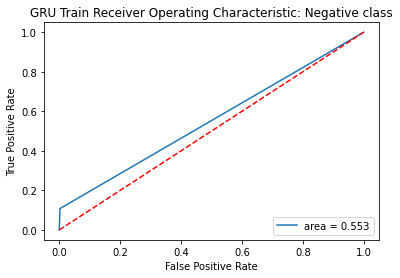

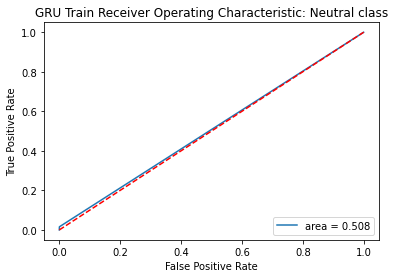

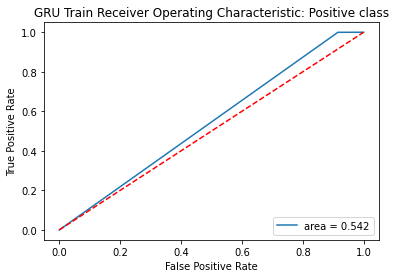


roc auc score test class Negative: 0.5263157894736842

roc auc score test class Neutral: 0.5

roc auc score test class Positive: 0.51


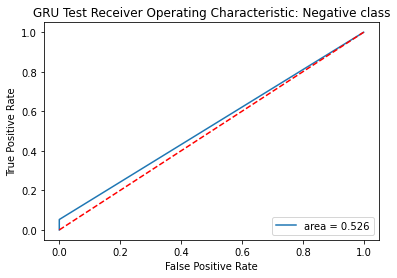

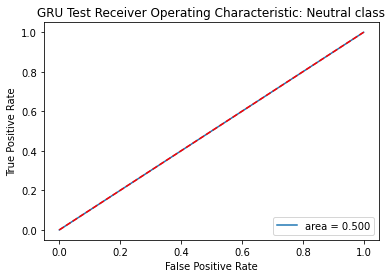

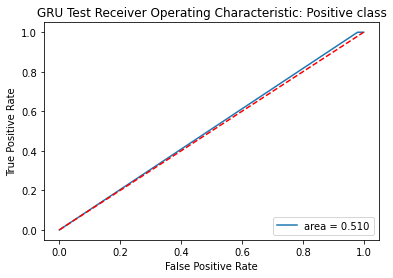

In [ ]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'GRU')

In [ ]:
test_y_pred = getSentiment(model_gru.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 5s 118ms/step
Test accuracy score 0.938 

Classification report

              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.65      0.35      0.35      1000
weighted avg       0.90      0.94      0.91      1000



In [ ]:
model_gru.save('gru_model')

Both the LSTM and GRU have similar performances.

### Simple LSTM & GRU

As we noticed, for deep learning model, ideally it should perform better than other machine learning models. But with the above architecture, both the LSTM and GRU are not performing as expected. So we can go with simple architechture by removing the kernel regularizers.

#### LSTM

In [60]:
# Model
model_lstm = Sequential()
model_lstm.add(Embedding(corpus_count, 150, input_length= maxlen))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dense(cat_classes, activation='softmax'))

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 150)          3000000   
                                                                 
 lstm_4 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                      

In [61]:
model_lstm.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [62]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [63]:
model_lstm.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 53s 461ms/step - loss: 0.6829 - f1_score: 0.3184 - val_loss: 0.6673 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 49s 456ms/step - loss: 0.3009 - f1_score: 0.3408 - val_loss: 0.4563 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 51s 477ms/step - loss: 0.2177 - f1_score: 0.4252 - val_loss: 0.3671 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 49s 459ms/step - loss: 0.1665 - f1_score: 0.4966 - val_loss: 0.2785 - val_f1_score: 0.3561
Epoch 5/10
107/107 [==============================] - 49s 456ms/step - loss: 0.1278 - f1_score: 0.6643 - val_loss: 0.2508 - val_f1_score: 0.4427
Epoch 6/10
107/107 [==============================] - 51s 473ms/step - loss: 0.0964 - f1_score: 0.7944 - val_loss: 0.3044 - val_f1_score: 0.4510
Epoch 7/10
107/107 [==============================] - 49s 460ms/step - loss: 0.0818 - f1_score: 0.8647 - val_loss: 0.3338 - val_f1

In [64]:
y_pred_train = getSentiment(model_lstm.predict(x_train_seq))
y_pred_test = getSentiment(model_lstm.predict(x_test_seq))

25/25 [==============================] - 3s 120ms/step


accuracy score train 0.9940625
accuracy score test 0.9375

Train classification report: LSTM

              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99        74
     Neutral       1.00      0.86      0.92       127
    Positive       0.99      1.00      1.00      2999

    accuracy                           0.99      3200
   macro avg       0.99      0.95      0.97      3200
weighted avg       0.99      0.99      0.99      3200


Test classification report: LSTM

              precision    recall  f1-score   support

    Negative       0.71      0.26      0.38        19
     Neutral       0.33      0.16      0.22        31
    Positive       0.95      0.99      0.97       750

    accuracy                           0.94       800
   macro avg       0.67      0.47      0.52       800
weighted avg       0.92      0.94      0.93       800


Train confusion matrix: LSTM

          Negative  Neutral  Positive
Negative        73        0         1
Ne

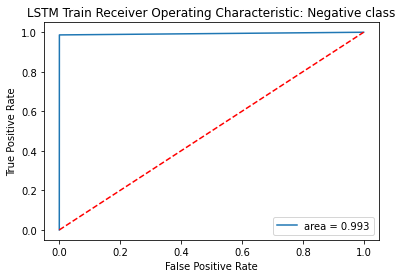

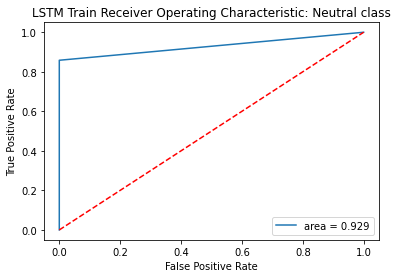

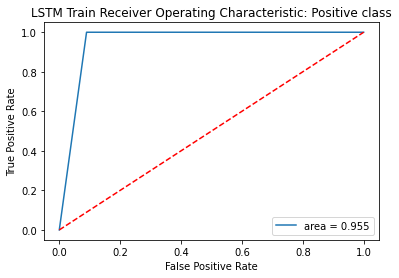


roc auc score test class Negative: 0.630298537637307

roc auc score test class Neutral: 0.5741432107051471

roc auc score test class Positive: 0.6133333333333333


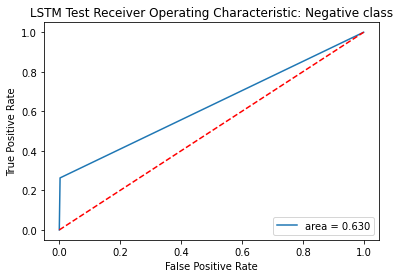

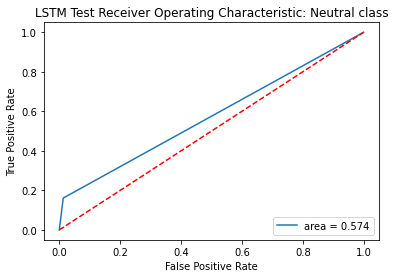

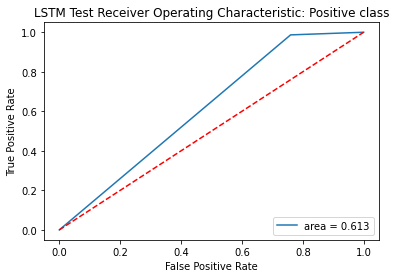

In [65]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'LSTM')

In [66]:
test_y_pred = getSentiment(model_lstm.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 4s 120ms/step
Test accuracy score 0.949 

Classification report

              precision    recall  f1-score   support

    Negative       0.75      0.38      0.50        24
     Neutral       0.56      0.23      0.33        39
    Positive       0.96      0.99      0.98       937

    accuracy                           0.95      1000
   macro avg       0.76      0.53      0.60      1000
weighted avg       0.94      0.95      0.94      1000



In [67]:
model_lstm.save('simple_lstm_model')

#### GRU

In [68]:
# Model
model_gru = Sequential()
model_gru.add(Embedding(corpus_count, 150, input_length= maxlen))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dense(cat_classes, activation='softmax'))

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 150)          3000000   
                                                                 
 lstm_4 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                      

In [69]:
model_gru.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [70]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [71]:
model_gru.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 47s 412ms/step - loss: 0.7260 - f1_score: 0.3000 - val_loss: 0.5185 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 52s 484ms/step - loss: 0.3197 - f1_score: 0.3613 - val_loss: 0.3577 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 39s 364ms/step - loss: 0.2198 - f1_score: 0.4134 - val_loss: 0.3127 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 39s 362ms/step - loss: 0.1716 - f1_score: 0.5501 - val_loss: 0.3017 - val_f1_score: 0.3226
Epoch 5/10
107/107 [==============================] - 40s 375ms/step - loss: 0.1240 - f1_score: 0.6822 - val_loss: 0.3053 - val_f1_score: 0.3434
Epoch 6/10
107/107 [==============================] - 39s 361ms/step - loss: 0.0956 - f1_score: 0.7959 - val_loss: 0.3519 - val_f1_score: 0.5189
Epoch 7/10
107/107 [==============================] - 39s 362ms/step - loss: 0.0682 - f1_score: 0.8647 - val_loss: 0.3493 - val_f1

In [72]:
y_pred_train = getSentiment(model_gru.predict(x_train_seq))
y_pred_test = getSentiment(model_gru.predict(x_test_seq))

25/25 [==============================] - 2s 87ms/step


accuracy score train 0.9915625
accuracy score test 0.93625

Train classification report: GRU

              precision    recall  f1-score   support

    Negative       0.96      0.89      0.92        74
     Neutral       1.00      0.86      0.92       127
    Positive       0.99      1.00      1.00      2999

    accuracy                           0.99      3200
   macro avg       0.98      0.92      0.95      3200
weighted avg       0.99      0.99      0.99      3200


Test classification report: GRU

              precision    recall  f1-score   support

    Negative       0.73      0.42      0.53        19
     Neutral       0.27      0.13      0.17        31
    Positive       0.95      0.98      0.97       750

    accuracy                           0.94       800
   macro avg       0.65      0.51      0.56       800
weighted avg       0.92      0.94      0.93       800


Train confusion matrix: GRU

          Negative  Neutral  Positive
Negative        66        0         8
Neut

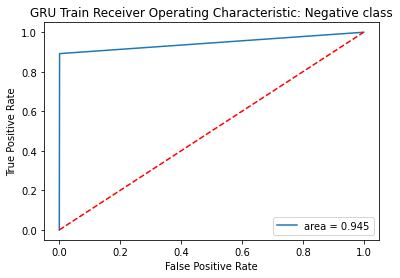

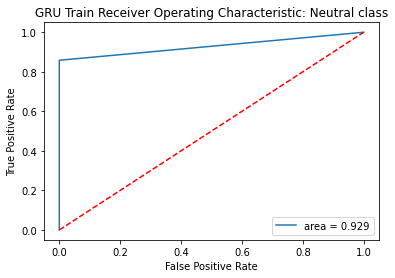

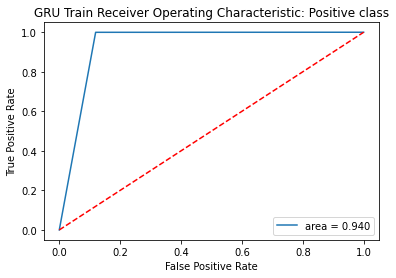


roc auc score test class Negative: 0.7086057011928028

roc auc score test class Neutral: 0.557363983388565

roc auc score test class Positive: 0.6213333333333333


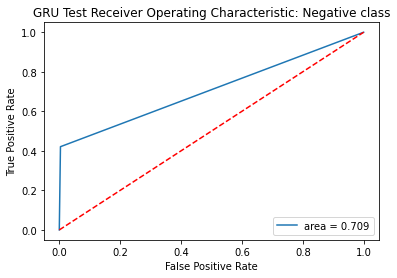

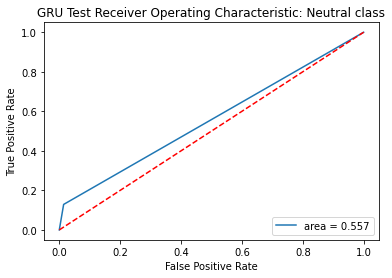

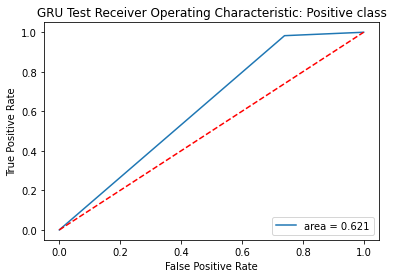

In [73]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'GRU')

In [74]:
test_y_pred = getSentiment(model_gru.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 3s 80ms/step
Test accuracy score 0.943 

Classification report

              precision    recall  f1-score   support

    Negative       0.58      0.29      0.39        24
     Neutral       0.59      0.26      0.36        39
    Positive       0.95      0.99      0.97       937

    accuracy                           0.94      1000
   macro avg       0.71      0.51      0.57      1000
weighted avg       0.93      0.94      0.93      1000



In [75]:
model_lstm.save('simple_gru_model')

New LSTM model performed better then the GRU and giving the best performance among all the models (based on macro f1-score on the test data).

#### LSTM & GRU with Word2Vec Embedding

Now instead of training the weights of embedding layer, we can provide our custom embedding weight matrix to the model. We can use word2vec to build the weight matrix.

We can compare the performance of LSTM/GRU with and without w2v embedding.

So first we need to build the w2v model using our existing text inputs and then use the word-vector matrix for the embedding.

In [76]:
# Create corpus
def getCorpus(reviews):
    sentences = []
    for review in reviews:
        sentences.append(review.split())
    return sentences

In [77]:
x_train_corpus = getCorpus(x_train)

In [78]:
x_train_corpus[0]

['decent', 'camera', 'clariti', 'screen', 'fast', 'download']

In [79]:
# params
num_features = 300
min_wc = 10
num_workers= -1

In [80]:
w2v = Word2Vec(sentences= x_train_corpus, size= num_features, min_count= min_wc, workers= num_workers)

In [81]:
w2v.save("word2vec.model")

In [82]:
w2v = Word2Vec.load('word2vec.model')

In [83]:
embedding_matrix = w2v.wv.syn0
embedding_matrix.shape

(706, 300)

In [84]:
corpus_count = embedding_matrix.shape[0]
maxlen = 200
cat_classes = 3
epoch = 10
batch_size = 30

In [85]:
tokenizer = Tokenizer(num_words=corpus_count)
tokenizer.fit_on_texts(x_train)

In [86]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
test_X_seq = tokenizer.texts_to_sequences(test_X)

In [87]:
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen= maxlen)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen= maxlen)
test_X_seq = sequence.pad_sequences(test_X_seq, maxlen= maxlen)

In [88]:
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

In [89]:
print(x_train_seq.shape)
print(x_test_seq.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 200)
(800, 200)
(3200,)
(800,)


##### LSTM with W2V Embedding, dropout and batch normalization

Now Dropout and BatchNormalization can be used to improve the performance.

In [90]:
model_lstm = Sequential()
model_lstm.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights= [embedding_matrix], input_length= maxlen))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dropout(0.2))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
model_lstm.add(Dense(cat_classes, activation='softmax'))

model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 300)          211800    
                                                                 
 lstm_5 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 32)                4128      
                                                      

In [91]:
model_lstm.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [92]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [93]:
model_lstm.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 65s 575ms/step - loss: 0.7329 - f1_score: 0.3061 - val_loss: 0.6617 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 56s 521ms/step - loss: 0.2880 - f1_score: 0.3371 - val_loss: 0.3287 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 55s 514ms/step - loss: 0.2430 - f1_score: 0.3520 - val_loss: 0.2795 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 57s 530ms/step - loss: 0.1952 - f1_score: 0.5066 - val_loss: 0.2624 - val_f1_score: 0.3226
Epoch 5/10
107/107 [==============================] - 55s 516ms/step - loss: 0.1669 - f1_score: 0.5806 - val_loss: 0.2450 - val_f1_score: 0.3224
Epoch 6/10
107/107 [==============================] - 57s 535ms/step - loss: 0.1323 - f1_score: 0.7065 - val_loss: 0.2645 - val_f1_score: 0.3226
Epoch 7/10
107/107 [==============================] - 56s 520ms/step - loss: 0.1066 - f1_score: 0.7564 - val_loss: 0.2923 - val_f1

In [94]:
y_pred_train = getSentiment(model_lstm.predict(x_train_seq))
y_pred_test = getSentiment(model_lstm.predict(x_test_seq))

25/25 [==============================] - 4s 146ms/step


accuracy score train 0.984375
accuracy score test 0.94

Train classification report: LSTM with W2V Embedding

              precision    recall  f1-score   support

    Negative       0.96      0.88      0.92        74
     Neutral       0.95      0.72      0.82       127
    Positive       0.99      1.00      0.99      2999

    accuracy                           0.98      3200
   macro avg       0.96      0.86      0.91      3200
weighted avg       0.98      0.98      0.98      3200


Test classification report: LSTM with W2V Embedding

              precision    recall  f1-score   support

    Negative       0.50      0.21      0.30        19
     Neutral       0.50      0.16      0.24        31
    Positive       0.95      0.99      0.97       750

    accuracy                           0.94       800
   macro avg       0.65      0.45      0.50       800
weighted avg       0.92      0.94      0.93       800


Train confusion matrix: LSTM with W2V Embedding

          Negative  Neut

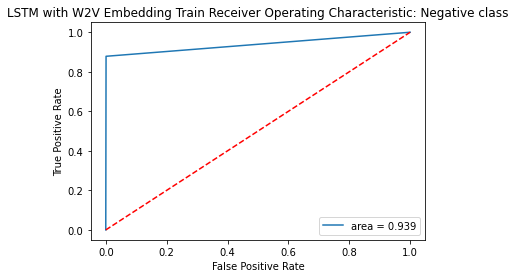

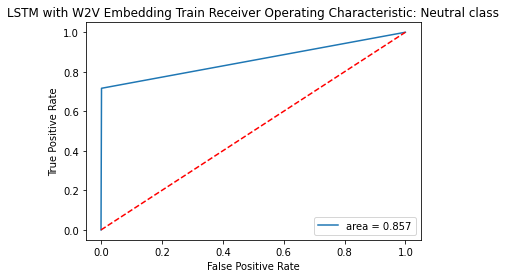

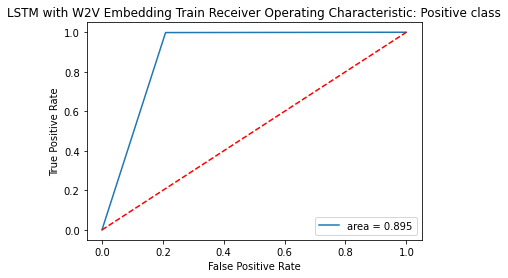


roc auc score test class Negative: 0.6027023384325089

roc auc score test class Neutral: 0.5773941859977348

roc auc score test class Positive: 0.6053333333333334


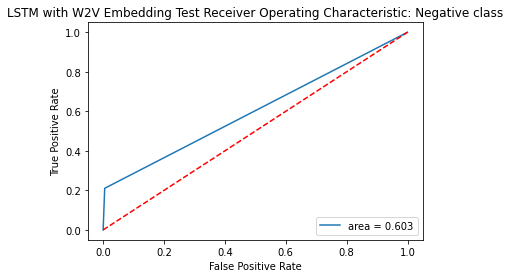

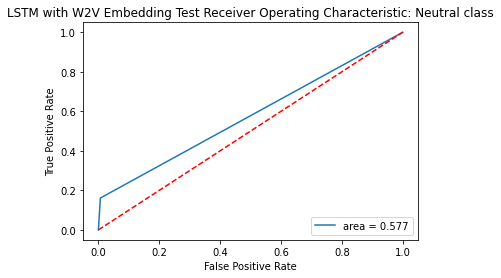

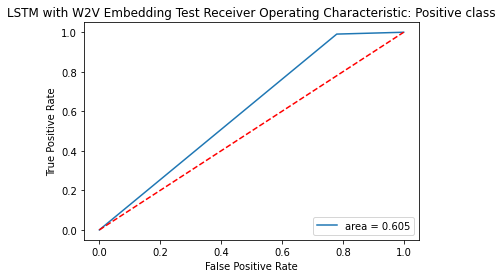

In [95]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'LSTM with W2V Embedding')

In [96]:
test_y_pred = getSentiment(model_lstm.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 5s 146ms/step
Test accuracy score 0.948 

Classification report

              precision    recall  f1-score   support

    Negative       0.69      0.38      0.49        24
     Neutral       0.55      0.28      0.37        39
    Positive       0.96      0.99      0.97       937

    accuracy                           0.95      1000
   macro avg       0.73      0.55      0.61      1000
weighted avg       0.94      0.95      0.94      1000



In [97]:
model_lstm.save('lstm_w2v_model')

So we can see, with our provided embedding weight matrix, the lstm model is not performing better than the existing lstm.

##### GRU with W2V Embedding, dropout and batch normalization

We can use Dropout and BatchNormalization here as well.

In [98]:
model_gru = Sequential()
model_gru.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights= [embedding_matrix], input_length= maxlen))
model_gru.add(GRU(128))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dropout(0.2))
model_gru.add(BatchNormalization())
model_gru.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
model_gru.add(Dense(cat_classes, activation='softmax'))

model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 300)          211800    
                                                                 
 gru_1 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_14 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 32)                4128      
                                                      

In [99]:
model_gru.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[F1Score(num_classes= 3, average= 'macro')])

In [100]:
model_gru.fit(x_train_seq, y_train_en, validation_data=(x_test_seq, y_test_en), 
               batch_size= batch_size, epochs=epoch, callbacks=[callback])

Epoch 1/10
107/107 [==============================] - 50s 438ms/step - loss: 0.4661 - f1_score: 0.3224 - val_loss: 0.4255 - val_f1_score: 0.3226
Epoch 2/10
107/107 [==============================] - 47s 440ms/step - loss: 0.2576 - f1_score: 0.3311 - val_loss: 0.2841 - val_f1_score: 0.3226
Epoch 3/10
107/107 [==============================] - 46s 430ms/step - loss: 0.2127 - f1_score: 0.4114 - val_loss: 0.2792 - val_f1_score: 0.3226
Epoch 4/10
107/107 [==============================] - 46s 428ms/step - loss: 0.1906 - f1_score: 0.5146 - val_loss: 0.2703 - val_f1_score: 0.3226
Epoch 5/10
107/107 [==============================] - 46s 430ms/step - loss: 0.1663 - f1_score: 0.5365 - val_loss: 0.2734 - val_f1_score: 0.3561
Epoch 6/10
107/107 [==============================] - 47s 439ms/step - loss: 0.1466 - f1_score: 0.6178 - val_loss: 0.2906 - val_f1_score: 0.3428
Epoch 7/10
107/107 [==============================] - 46s 428ms/step - loss: 0.1247 - f1_score: 0.6844 - val_loss: 0.3106 - val_f1

In [101]:
y_pred_train = getSentiment(model_gru.predict(x_train_seq))
y_pred_test = getSentiment(model_gru.predict(x_test_seq))

25/25 [==============================] - 3s 109ms/step


accuracy score train 0.9759375
accuracy score test 0.92625

Train classification report: GRU with W2V Embedding

              precision    recall  f1-score   support

    Negative       0.82      0.62      0.71        74
     Neutral       0.89      0.67      0.77       127
    Positive       0.98      1.00      0.99      2999

    accuracy                           0.98      3200
   macro avg       0.90      0.76      0.82      3200
weighted avg       0.97      0.98      0.97      3200


Test classification report: GRU with W2V Embedding

              precision    recall  f1-score   support

    Negative       0.57      0.21      0.31        19
     Neutral       0.13      0.06      0.09        31
    Positive       0.94      0.98      0.96       750

    accuracy                           0.93       800
   macro avg       0.55      0.42      0.45       800
weighted avg       0.90      0.93      0.91       800


Train confusion matrix: GRU with W2V Embedding

          Negative  Neu

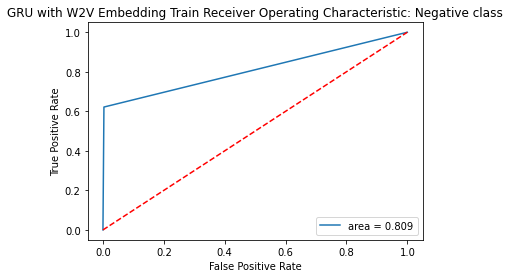

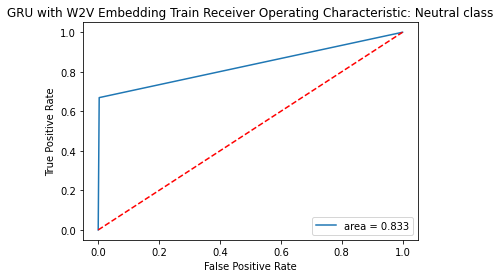

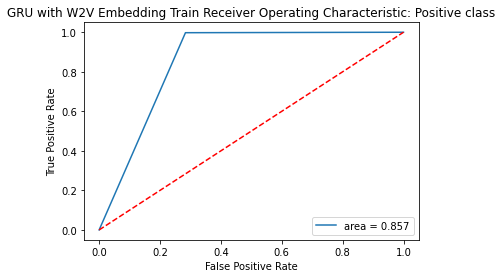


roc auc score test class Negative: 0.6033425432980659

roc auc score test class Neutral: 0.5238055287554008

roc auc score test class Positive: 0.56


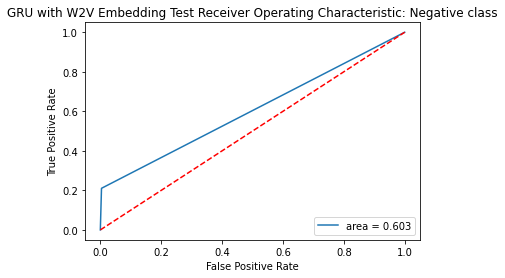

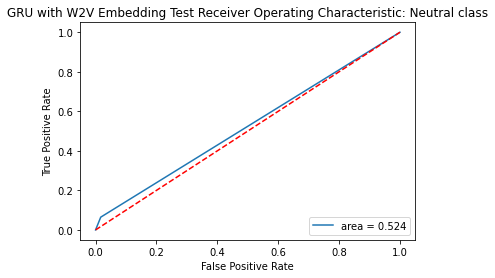

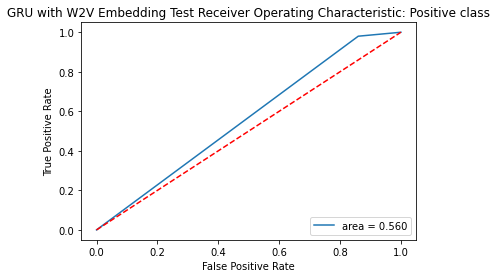

In [102]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'GRU with W2V Embedding')

In [103]:
test_y_pred = getSentiment(model_gru.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 4s 107ms/step
Test accuracy score 0.938 

Classification report

              precision    recall  f1-score   support

    Negative       0.45      0.21      0.29        24
     Neutral       0.50      0.23      0.32        39
    Positive       0.95      0.99      0.97       937

    accuracy                           0.94      1000
   macro avg       0.64      0.48      0.52      1000
weighted avg       0.92      0.94      0.93      1000



In [104]:
model_gru.save('gru_w2v_model')

LSTM with provided embedding matrix is performing much better than the same with GRU and its performance is similar to the simple LSTM.

So LSTM with w2v embedding gave the best performance till now.

So we can let the embedding layer to train itself by going for simple LSTM/GRU models, but hyper parameter tunning can be done on those models.

#### 6. Find the best setting of LSTM (Neural Net) and GRU that can best classify the reviews as positive, negative, and neutral.

We can take the input data and use keras tuner RandomSearch to find best model structure and params.

As we got better performance by using the self trained embedding layer without explicit embedding matrix weights, we can use the same input here as well.

In [106]:
# initiate params
corpus_count = 20000
maxlen = 200
cat_classes = 3
epoch = 5
batch_size = 30
trials = 3

In [107]:
# Prepare input
tokenizer = Tokenizer(num_words=corpus_count)
tokenizer.fit_on_texts(x_train)

In [108]:
pickle.dump(tokenizer, open('keras_tokenizer.pkl', 'wb'))

In [109]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
test_X_seq = tokenizer.texts_to_sequences(test_X)

In [110]:
x_train_seq = sequence.pad_sequences(x_train_seq, maxlen= maxlen)
x_test_seq = sequence.pad_sequences(x_test_seq, maxlen= maxlen)
test_X_seq = sequence.pad_sequences(test_X_seq, maxlen= maxlen)

In [111]:
# Encode Y values
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

In [112]:
print(x_train_seq.shape)
print(x_test_seq.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 200)
(800, 200)
(3200,)
(800,)


In [115]:
# Model builder
def modelBuilder(hy_param):
    # input
    inputs = Input(shape=(200,))
    # Tokenization/embedding param
    corpus_count = hy_param.Choice('corpus_count', [5000, 10000, 15000, 20000])
    maxlen = hy_param.Choice('maxlen', [150, 200, 250, 300])
    embedding_features = hy_param.Choice('embedding_features', [150, 200, 250, 300])
    # learning rate param
    lr = hy_param.Choice('learning_rate', [1e-3, 5e-4])
    # regularization param
    regL1 = hy_param.Float('regularization1', 0.0, 0.1, step=0.005)
    regL2 = hy_param.Float('regularization2', 0.0, 0.1, step=0.005)
    # kernel initialization param
    kernel_initializers = hy_param.Choice('kernel_initializer', ['he_uniform', 'he_normal'])
    # dropout 1 param
    dropout1 = hy_param.Float('dropout1', 0, 0.5, step=0.2)
    # dropout 2 param
    dropout2 = hy_param.Float('dropout2', 0, 0.5, step=0.2)

    # Embedding
    x = Embedding(corpus_count, embedding_features, input_length= maxlen)(inputs)
    
    # RNN
    RNN_layers = hy_param.Int('rnn_layers', 1, 3)
    for i in range(RNN_layers):
        if i < RNN_layers-1:
            seq = True
        else:
            seq = False
        i = str(i)
        filters = hy_param.Int('filters_' + i, 64, 260, step=64)
        rnn_dropout = hy_param.Float('dropout_rnn' + i, 0, 0.5, step=0.2)
        rnn_type = hy_param.Choice('rnn_type_' + i, values=['lstm', 'gru'])
        if rnn_type == 'lstm':
            x = LSTM(filters, activation= 'relu', dropout= rnn_dropout, return_sequences= seq)(x)
        elif rnn_type == 'gru':
            x = GRU(filters, activation= 'relu', dropout= rnn_dropout, return_sequences= seq)(x)
    
    # Dropout 1
    x = Dropout(dropout1)(x)
    
    # Batch normalization 1    
    x = BatchNormalization()(x)
    
    # Dense 1 number of layers param
    dense_layers1 = hy_param.Int('dense_layers1', 1, 3)

    # Dense 1
    for i in range(dense_layers1):
        dense_filters1 = 128 / (2 ** i)
        x = Dense(dense_filters1, activation='relu', kernel_regularizer= L1L2(l1=regL1, l2=regL2), kernel_initializer=kernel_initializers)(x)
    
    # Dropout 2
    x = Dropout(dropout2)(x)
    
    # Batch normalization 2   
    x = BatchNormalization()(x)
    
    # Dense 2 filter param
    dense_filters2 = hy_param.Int('dense_layers2', 10, 21, step= 5)

    # Dense 2
    x = Dense(dense_filters2, activation='relu', kernel_regularizer= L1L2(l1=regL1, l2=regL2), kernel_initializer=kernel_initializers)(x)
    
    # Dense+softmax
    outputs = Dense(cat_classes, activation='softmax', kernel_regularizer= L1L2(l1=regL1, l2=regL2))(x)
    
    # Model
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer= Adam(lr),
                  metrics=[F1Score(num_classes= 3, average= 'macro')])
    
    return model

In [116]:
tuner = RandomSearch(modelBuilder, objective='val_loss', max_trials=trials,
                     project_name='ECommerce RNN Result')

In [117]:
tuner.search_space_summary()

Search space summary
Default search space size: 15
corpus_count (Choice)
{'default': 5000, 'conditions': [], 'values': [5000, 10000, 15000, 20000], 'ordered': True}
maxlen (Choice)
{'default': 150, 'conditions': [], 'values': [150, 200, 250, 300], 'ordered': True}
embedding_features (Choice)
{'default': 150, 'conditions': [], 'values': [150, 200, 250, 300], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005], 'ordered': True}
regularization1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
regularization2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
kernel_initializer (Choice)
{'default': 'he_uniform', 'conditions': [], 'values': ['he_uniform', 'he_normal'], 'ordered': False}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.2, 'sampling': None}
dropout2 (Float

In [118]:
callback = EarlyStopping(monitor='val_loss', patience=4)

In [119]:
tuner.search(x_train_seq, y_train_en, batch_size=batch_size, epochs=epoch,
             validation_data=(x_test_seq, y_test_en), callbacks=[callback])

Trial 3 Complete [00h 06m 04s]
val_loss: 9.555488586425781

Best val_loss So Far: 1.0153387784957886
Total elapsed time: 00h 18m 58s


In [120]:
tuner.results_summary()

Results summary
Results in ./ECommerce RNN Result
Showing 10 best trials
Trial summary
Hyperparameters:
corpus_count: 5000
maxlen: 300
embedding_features: 250
learning_rate: 0.0005
regularization1: 0.025
regularization2: 0.0
kernel_initializer: he_uniform
dropout1: 0.0
dropout2: 0.2
rnn_layers: 1
filters_0: 128
dropout_rnn0: 0.4
rnn_type_0: gru
dense_layers1: 1
dense_layers2: 15
Score: 1.0153387784957886
Trial summary
Hyperparameters:
corpus_count: 15000
maxlen: 150
embedding_features: 300
learning_rate: 0.0005
regularization1: 0.075
regularization2: 0.05
kernel_initializer: he_normal
dropout1: 0.0
dropout2: 0.4
rnn_layers: 2
filters_0: 128
dropout_rnn0: 0.2
rnn_type_0: lstm
dense_layers1: 1
dense_layers2: 10
filters_1: 64
dropout_rnn1: 0.0
rnn_type_1: lstm
Score: 7.9572625160217285
Trial summary
Hyperparameters:
corpus_count: 15000
maxlen: 150
embedding_features: 200
learning_rate: 0.001
regularization1: 0.03
regularization2: 0.085
kernel_initializer: he_uniform
dropout1: 0.0
dropout2

In [121]:
best_neural_model = tuner.get_best_models(num_models=1)[0]
best_neural_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 250)          1250000   
                                                                 
 gru (GRU)                   (None, 128)               145920    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                             

In [122]:
y_pred_train = getSentiment(best_neural_model.predict(x_train_seq))
y_pred_test = getSentiment(best_neural_model.predict(x_test_seq))

25/25 [==============================] - 3s 102ms/step


accuracy score train 0.9371875
accuracy score test 0.9375

Train classification report: Best Neural Net

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        74
     Neutral       0.00      0.00      0.00       127
    Positive       0.94      1.00      0.97      2999

    accuracy                           0.94      3200
   macro avg       0.31      0.33      0.32      3200
weighted avg       0.88      0.94      0.91      3200


Test classification report: Best Neural Net

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        19
     Neutral       0.00      0.00      0.00        31
    Positive       0.94      1.00      0.97       750

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800


Train confusion matrix: Best Neural Net

          Negative  Neutral  Positive
Negativ

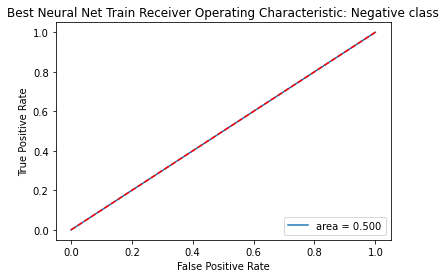

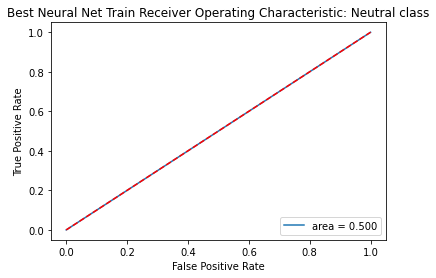

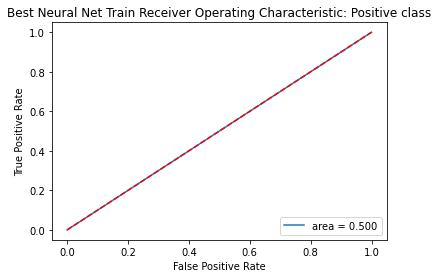


roc auc score test class Negative: 0.5

roc auc score test class Neutral: 0.5

roc auc score test class Positive: 0.5


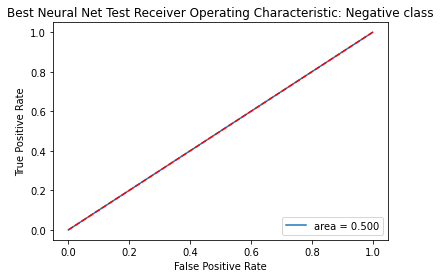

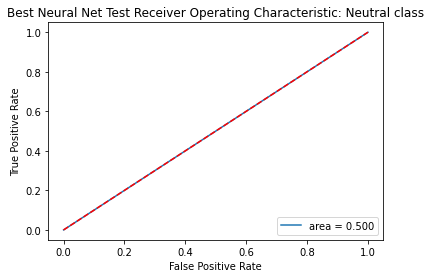

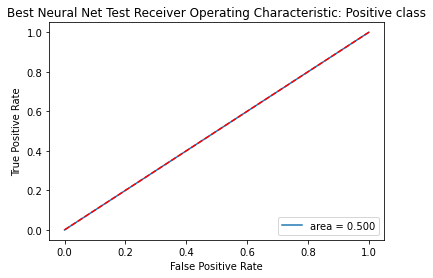

In [123]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'Best Neural Net')

In [124]:
test_y_pred = getSentiment(best_neural_model.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 4s 103ms/step
Test accuracy score 0.937 

Classification report

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.94      0.91      1000



In [125]:
best_neural_model.save('best_neural_net_random')

In [126]:
tuner = BayesianOptimization(modelBuilder, objective='val_loss', max_trials=trials,
                     project_name='ECommerce RNN Result Bayesian')

In [127]:
tuner.search_space_summary()

Search space summary
Default search space size: 15
corpus_count (Choice)
{'default': 5000, 'conditions': [], 'values': [5000, 10000, 15000, 20000], 'ordered': True}
maxlen (Choice)
{'default': 150, 'conditions': [], 'values': [150, 200, 250, 300], 'ordered': True}
embedding_features (Choice)
{'default': 150, 'conditions': [], 'values': [150, 200, 250, 300], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005], 'ordered': True}
regularization1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
regularization2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.005, 'sampling': None}
kernel_initializer (Choice)
{'default': 'he_uniform', 'conditions': [], 'values': ['he_uniform', 'he_normal'], 'ordered': False}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.2, 'sampling': None}
dropout2 (Float

In [128]:
tuner.search(x_train_seq, y_train_en, batch_size=batch_size, epochs=epoch,
             validation_data=(x_test_seq, y_test_en), callbacks=[callback])

Trial 3 Complete [00h 09m 17s]
val_loss: nan

Best val_loss So Far: 0.6675423383712769
Total elapsed time: 00h 21m 27s


In [129]:
tuner.results_summary()

Results summary
Results in ./ECommerce RNN Result Bayesian
Showing 10 best trials
Trial summary
Hyperparameters:
corpus_count: 15000
maxlen: 300
embedding_features: 300
learning_rate: 0.001
regularization1: 0.05
regularization2: 0.03
kernel_initializer: he_normal
dropout1: 0.2
dropout2: 0.0
rnn_layers: 1
filters_0: 128
dropout_rnn0: 0.4
rnn_type_0: lstm
dense_layers1: 1
dense_layers2: 20
filters_1: 192
dropout_rnn1: 0.4
rnn_type_1: gru
filters_2: 192
dropout_rnn2: 0.4
rnn_type_2: gru
Score: 0.6675423383712769
Trial summary
Hyperparameters:
corpus_count: 20000
maxlen: 300
embedding_features: 250
learning_rate: 0.0005
regularization1: 0.09
regularization2: 0.1
kernel_initializer: he_uniform
dropout1: 0.2
dropout2: 0.4
rnn_layers: 3
filters_0: 64
dropout_rnn0: 0.4
rnn_type_0: gru
dense_layers1: 3
dense_layers2: 15
filters_1: 64
dropout_rnn1: 0.0
rnn_type_1: lstm
filters_2: 64
dropout_rnn2: 0.0
rnn_type_2: lstm
Score: 9.053215026855469
Trial summary
Hyperparameters:
corpus_count: 5000
maxl

In [130]:
best_neural_model = tuner.get_best_models(num_models=1)[0]
best_neural_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          4500000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                             

In [131]:
y_pred_train = getSentiment(best_neural_model.predict(x_train_seq))
y_pred_test = getSentiment(best_neural_model.predict(x_test_seq))

25/25 [==============================] - 4s 144ms/step


accuracy score train 0.9371875
accuracy score test 0.9375

Train classification report: Best Neural Net (Bayesian)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        74
     Neutral       0.00      0.00      0.00       127
    Positive       0.94      1.00      0.97      2999

    accuracy                           0.94      3200
   macro avg       0.31      0.33      0.32      3200
weighted avg       0.88      0.94      0.91      3200


Test classification report: Best Neural Net (Bayesian)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        19
     Neutral       0.00      0.00      0.00        31
    Positive       0.94      1.00      0.97       750

    accuracy                           0.94       800
   macro avg       0.31      0.33      0.32       800
weighted avg       0.88      0.94      0.91       800


Train confusion matrix: Best Neural Net (Bayesian)

          Ne

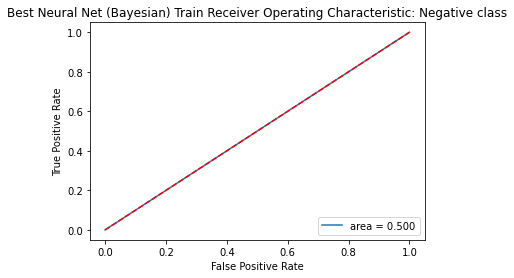

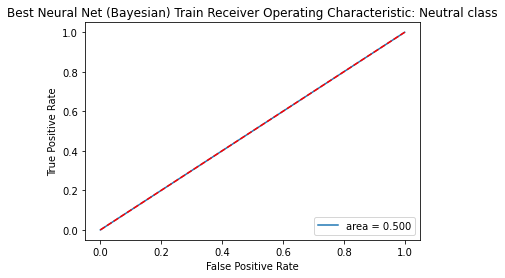

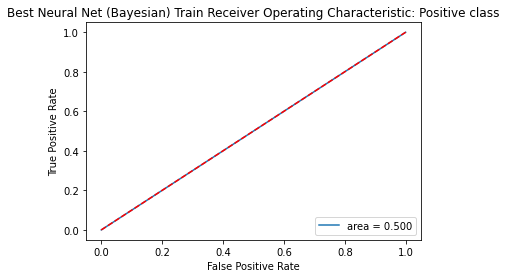


roc auc score test class Negative: 0.5

roc auc score test class Neutral: 0.5

roc auc score test class Positive: 0.5


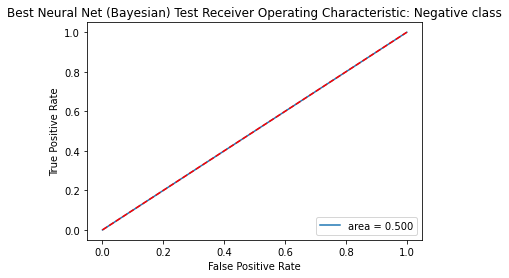

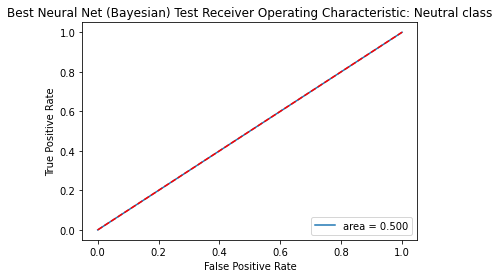

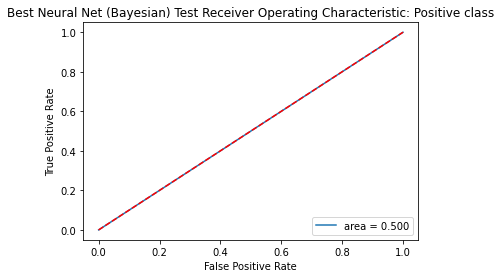

In [132]:
getPerformance(y_train_label, y_pred_train, y_test_label, y_pred_test, classes, 'Best Neural Net (Bayesian)')

In [133]:
test_y_pred = getSentiment(best_neural_model.predict(test_X_seq))
print('Test accuracy score {} \n'.format(accuracy_score(test_y, test_y_pred)))
print('Classification report\n')
print(classification_report(test_y, test_y_pred))

32/32 [==============================] - 5s 143ms/step
Test accuracy score 0.937 

Classification report

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.00      0.00      0.00        39
    Positive       0.94      1.00      0.97       937

    accuracy                           0.94      1000
   macro avg       0.31      0.33      0.32      1000
weighted avg       0.88      0.94      0.91      1000



In [134]:
best_neural_model.save('best_neural_net_bayesian')

Still, by looking that the perormance, LSTM (w2v_lstm_model) is performing the best.

### Topic Modeling

#### 7. Cluster similar reviews.

In [ ]:
ecomp_train_text = pd.read_pickle("ecomp_train_processed.pkl")
ecomp_train_text = ecomp_train_text[['reviews.clean_text', 'sentiment']]

In [ ]:
ecomp_train_text['sentiment'].value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

In [ ]:
text_pos = ecomp_train_text[ecomp_train_text['sentiment'] == 'Positive'].drop(['sentiment'], axis=1)[:93]
text_neg = ecomp_train_text[ecomp_train_text['sentiment'] == 'Negative'].drop(['sentiment'], axis=1)[:93]
text_neu = ecomp_train_text[ecomp_train_text['sentiment'] == 'Neutral'].drop(['sentiment'], axis=1)[:93]

In [ ]:
X_text = pd.concat([text_pos, text_neg, text_neu], axis=0)
X_text.shape

(279, 1)

In [ ]:
# get tfidf feature vectors
tfidf = TfidfVectorizer(max_features = 5000, ngram_range=(1, 2))
X_text_vec = tfidf.fit_transform(X_text.iloc[:, 0])

We can use KMeans clustering here.

In [ ]:
cost =[]
for i in range(1, 10):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(X_text_vec)
    cost.append(KM.inertia_)

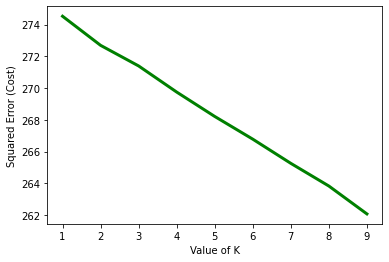

In [ ]:
plt.plot(range(1, 10), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

We can choose 5 as optimum K value for Kmeans, because we are not seeing any elbow point.

In [ ]:
KM = KMeans(n_clusters = 5, max_iter = 500)
labels = KM.fit_predict(X_text_vec)

We can view the result with the help of PCA.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_text_vec.toarray())

In [ ]:
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

In [ ]:
df['Text'] = X_text.iloc[:, 0]

In [ ]:
df['label'] = labels

In [ ]:
df.shape

(279, 4)

In [ ]:
df[:1]

,PC1,PC2,Text,label
0,-0.019831,0.012978,purchas black fridaypro great price even salev...,4


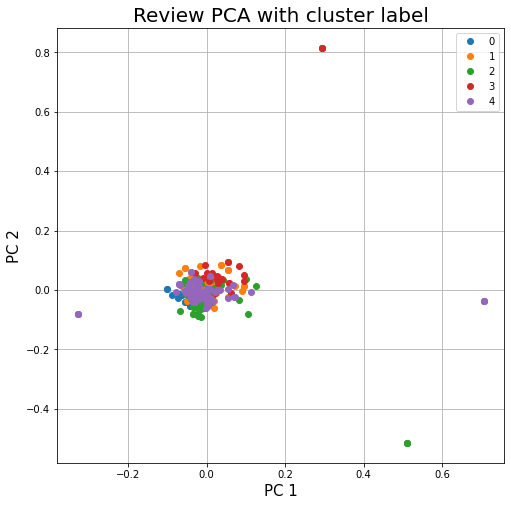

In [ ]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Review PCA with cluster label', fontsize = 20)
targets = sorted(list(df['label'].unique()))
for target in targets:
    idx = df['label'] == target
    ax.plot(df.loc[idx, 'PC1'], df.loc[idx, 'PC2'], linestyle='none', marker='o', label=targets)
ax.legend(targets)
ax.grid()

Lets check review texts for different clusters

In [ ]:
for i in range(5):
    print('cluster ' + str(i))
    text_i = df[df['label'] ==i]['Text']
    print(text_i[:1].values)
    print(text_i[1:2].values)
    print('------------')

cluster 0
['purchas two amazon echo plus two dot plus four fire stick hub philip hue lamp famili christma happi purchas learn much alexa start daili routin alexa program whatev would like includ news weather music horoscop also start day compliment think import alexa gave best chili recip mean best call chili want husband use alexa stay organ busi date remind way go']
['replac fire kindl love hd qualiti']
------------
cluster 1
['good product exact want good price']
['great product light weight wish wifi download onlin']
------------
cluster 2
['averag alexa option show thing screen still limit']
['rd one ive purchas ive bought one niec case compar one held protect tablet mani time drop']
------------
cluster 3
['cheap run chrome stuff return store']
['prime almost must keep amazon stuff one place']
------------
cluster 4
['purchas black fridaypro great price even saleveri power fast quad core processor amaz soundwel builtcon amazon ad amazon need subsid tablet remov add pay inabl acce

We can use the preprocessed texts and do topic modelling on top of that using gensim library.

First we need to build a text corpus and use LDA model for topic modelling.

In [135]:
ecomp_train_text = pd.read_pickle("ecomp_train_processed.pkl")
cleaned_texts = ecomp_train_text['reviews.clean_text'].values

In [136]:
corpus = [text.split() for text in cleaned_texts]
print('total texts', len(corpus))
print(corpus[0][:10])

total texts 4000
['purchas', 'black', 'fridaypro', 'great', 'price', 'even', 'saleveri', 'power', 'fast', 'quad']


In [137]:
dictionary = corpora.Dictionary(corpus)
print(dictionary)

Dictionary(3697 unique tokens: ['abl', 'access', 'accomplish', 'ad', 'add']...)


In [138]:
doc_matrix = [dictionary.doc2bow(text) for text in corpus]

In [139]:
num_topic = 10
lda = LdaModel(doc_matrix, num_topics= num_topic, id2word= dictionary, passes= 40)

In [140]:
topics = lda.show_topics()
for topic in topics:
  print(topic)
  print('----------------------')

(0, '0.063*"love" + 0.036*"bought" + 0.030*"old" + 0.029*"year" + 0.026*"kindl" + 0.024*"tablet" + 0.024*"use" + 0.022*"one" + 0.019*"easi" + 0.013*"gift"')
----------------------
(1, '0.029*"kindl" + 0.028*"one" + 0.024*"purchas" + 0.021*"read" + 0.017*"book" + 0.012*"love" + 0.012*"new" + 0.012*"small" + 0.012*"bought" + 0.011*"work"')
----------------------
(2, '0.031*"read" + 0.027*"devic" + 0.027*"book" + 0.023*"amazon" + 0.019*"great" + 0.019*"fire" + 0.016*"kindl" + 0.016*"best" + 0.013*"size" + 0.012*"buy"')
----------------------
(3, '0.030*"use" + 0.024*"screen" + 0.022*"easi" + 0.020*"sound" + 0.017*"good" + 0.015*"speaker" + 0.013*"like" + 0.013*"light" + 0.012*"qualiti" + 0.011*"get"')
----------------------
(4, '0.020*"amazon" + 0.020*"tablet" + 0.019*"would" + 0.017*"use" + 0.017*"buy" + 0.015*"product" + 0.015*"great" + 0.013*"recommend" + 0.013*"good" + 0.013*"set"')
----------------------
(5, '0.070*"great" + 0.057*"tablet" + 0.049*"price" + 0.029*"kid" + 0.022*"good"

Now lets create a dataframe to view these topics in a better way. We can choose top 15 values for each topic.

In [141]:
lda.show_topic(0, topn = 15)

[('love', 0.062940404),
 ('bought', 0.036242247),
 ('old', 0.02960274),
 ('year', 0.029061344),
 ('kindl', 0.026133668),
 ('tablet', 0.024342084),
 ('use', 0.024142405),
 ('one', 0.021713383),
 ('easi', 0.018683134),
 ('gift', 0.013292712),
 ('daughter', 0.013235307),
 ('game', 0.012386512),
 ('son', 0.012087541),
 ('fire', 0.011921115),
 ('purchas', 0.011557242)]

In [142]:
topic_dict = {}
for i in range(num_topic):
  words = lda.show_topic(i, topn = 15)
  topic_dict['Topic-'+str(i)] = [word[0] for word in words]

In [143]:
topic_df = pd.DataFrame(topic_dict)
topic_df

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4,Topic-5,Topic-6,Topic-7,Topic-8,Topic-9
0,love,kindl,read,use,amazon,great,tablet,love,batteri,echo
1,bought,one,devic,screen,tablet,tablet,use,great,life,alexa
2,old,purchas,book,easi,would,price,app,echo,read,show
3,year,read,amazon,sound,use,kid,great,tap,make,love
4,kindl,book,great,good,buy,good,game,gift,much,use
5,tablet,love,fire,speaker,product,need,good,learn,worth,music
6,use,new,kindl,like,great,product,play,buy,kindl,great
7,one,small,best,light,recommend,recommend,fire,best,last,home
8,easi,bought,size,qualiti,good,work,amazon,product,generat,devic
9,gift,work,buy,get,set,like,work,light,book,video


Lets display all the topics for better insights.

In [145]:
lda_display = pyLDAvis.gensim_models.prepare(lda, doc_matrix, dictionary, sort_topics = False)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_display)

In [146]:
pyLDAvis.save_html(lda_display, 'lda_display.html')

Ecommerce sentiment analysis was perfomed with ML and DL models, clustering and topic modeling.